# Manhattan and Forest Plots

In [1]:
import glob
import itertools as it 
import os
import sys
from textwrap import wrap

from adjustText import adjust_text
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import seaborn as sns
sns.set(rc={'font.sans-serif':'Helvetica'})
sns.set(style='whitegrid', rc={'font.sans-serif':'Helvetica'})

sys.path.insert(0, os.path.realpath('../../h2-estimation/helpers/'))
import make_stan_input_files

from IPython.display import display, HTML

%matplotlib inline

In [2]:
phenos = pd.read_table('../../h2-estimation/data/traits.tsv', index_col=0)
phenos = phenos[phenos.phenotype.isnull() == False]

In [3]:
fn = ('/oak/stanford/groups/mrivas/public_data/gencode.v19_20170526/parsing/'
      'gencode.v19.annotation.table.tsv')
gene_info = pd.read_table(fn, index_col=0)
gene_info.index = [x.split('.')[0] for x in gene_info.index]

fn = '/oak/stanford/groups/mrivas/private_data/ukbb/gwas_results/hybrid.tsv'
hybrid = pd.read_table(fn)
fn = ('/oak/stanford/groups/mrivas/private_data/ukbb/variant_filtering/'
      'variant_filter_table_no_consequence.tsv.gz')
varinfo = pd.read_table(fn)
varinfo_f = varinfo[(varinfo['Consequence'] == 'missense_variant') | 
                    (varinfo.LoF.isnull() == False)]

/home/groups/mrivas/software/anaconda2_sherlock2/envs/h2-estimation/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (26,27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Functions

In [4]:
chrom_sizes = pd.Series(
    {1: 249250621,
     10: 135534747,
     11: 135006516,
     12: 133851895,
     13: 115169878,
     14: 107349540,
     15: 102531392,
     16: 90354753,
     17: 81195210,
     18: 78077248,
     19: 59128983,
     2: 243199373,
     20: 63025520,
     21: 48129895,
     22: 51304566,
     3: 198022430,
     4: 191154276,
     5: 180915260,
     6: 171115067,
     7: 159138663,
     8: 146364022,
     9: 141213431,
    }
)
chrom_sizes_norm = chrom_sizes / chrom_sizes.max()

In [5]:
def read_results(fn):
    res = pd.read_csv(fn).drop_duplicates()
    res = res.sort_values(by=['chrom', 'pos'])
    vc = res.gene.value_counts()
    vc = vc[vc == 1]
    res = res[res.gene.isin(vc.index)]
    res.index = res.gene
    res['bma'] = (res['l10bf'] + res['l10bf2']) / 2
    if 'CTD-3064M3.3' in res.index:
        res = res.drop('CTD-3064M3.3')
    if 'ZFAT-AS1' in res.index:
        res = res.drop('ZFAT-AS1')
    if 'FLG-AS1' in res.index:
        res = res.drop('FLG-AS1')
    return(res)

In [6]:
# def plot_manhattan(fn, ax, code, offsets, global_ymin, global_ymax, col='l10bf', 
#                    loc='upper left', ncol=1, legend=True):
def plot_manhattan(fn, ax, col='l10bf', loc='upper left', ncol=1, legend=True):
    res = read_results(fn)
    # Assign x coordinates for each association.
    res['xpos'] = np.nan
    chrom_vc = res['chrom'].value_counts()
    # total_length is arbitrary, but it's a little easier than working with the 
    # normalize chromosome sizes to avoid small numbers.
    total_length = 1000
    right = chrom_sizes_norm.cumsum()
    right = right / right[22] * total_length
    left = chrom_sizes_norm.cumsum() - chrom_sizes_norm[1]
    left = pd.Series(0, range(1, 23))
    left[1:23] = right[0:21].values
    for chrom in range(1, 23):
        res.loc[res['chrom'] == chrom, 'xpos'] = np.linspace(
            left[chrom], right[chrom], chrom_vc[chrom])
    # Assign colors.
    grey = mpl.colors.to_rgb('grey')
    light_grey = (0.9, 0.9, 0.9)
    middle_grey = (0.8, 0.8, 0.8)
    res['color'] = 'black'
    for chrom in range(1, 23)[0::2]:
        ind = res[(res[col] < 2) & (res['chrom'] == chrom)].index
        res.loc[ind, 'color'] = pd.Series([grey for x in ind], index=ind)
    for chrom in range(1, 23)[1::2]:
        ind = res[(res[col] < 2) & (res['chrom'] == chrom)].index
        res.loc[ind, 'color'] = pd.Series([middle_grey for x in ind], index=ind)
    for chrom in range(1, 23):
        ind = res[(res[col] >= 2) & (res[col] < 3) & (res['chrom'] == chrom)].index
        res.loc[ind, 'color'] = pd.Series([sns.color_palette()[0] for x in ind], index=ind)
        ind = res[(res[col] >= 3) & (res['chrom'] == chrom)].index
        res.loc[ind, 'color'] = pd.Series([sns.color_palette()[1] for x in ind], index=ind)
    
    # Plot
    labels = ['$\log_{10}$ BF < 2', '$2 \leq \log_{10}$ BF < 3', '$\log_{10}$ BF > 3']
    for i,ind in enumerate([
        res[res[col] < 2].index,
        res[(res[col] >= 2) & (res[col] < 3)].index,
        res[(res[col] >= 3)].index,
    ]):
        ax.scatter(
            res.loc[ind, 'xpos'], 
            res.loc[ind, col], 
            color=res.loc[ind, 'color'], 
            s=15, 
            alpha=0.75,
            rasterized=True,
            label=labels[i],
        )
    ax.grid(axis='x')
    ax.grid(axis='y')
    ax.grid(axis='y', alpha=0.5, ls='--')
    # for chrom in range(1, 23)[0::2]:
    #     ax.axvspan(left[chrom], right[chrom], facecolor=(0.4, 0.4, 0.4), alpha=0.2, lw=0)
    ax.set_xlim(-5, total_length + 5)
    ymin,ymax = ax.get_ylim()
    ax.set_ylim(-5, ymax)
    # Set chromosome labels
    ind = range(1, 23)[0::2]
    ax.set_xticks(left[ind] + (right[ind] - left[ind]) / 2)
    ax.set_xticklabels(ind, fontsize=8)
    ax.set_ylabel('$\log_{10}$ Bayes Factor', fontsize=8)
    for t in ax.get_xticklabels() + ax.get_yticklabels():
        t.set_fontsize(8)
    if legend:
        ax.legend(fontsize=7, framealpha=0.5, frameon=True, facecolor='white',
                  loc=loc, ncol=ncol)
    
    # add_annotations(fn, ax, offsets, col=col)
    # title = phenos.loc['HC382', 'phenotype'].replace('_', ' ')
    # title = title[0].upper() + title[1:]
    # ax.set_title(title, fontsize=8)
    # ax.set_ylim(global_ymin, global_ymax)
    
    return(ax, res)

In [7]:
def add_annotations(fn, ax, offsets, col='l10bf'):
    for i in annotations[fn]:
        if i in offsets.keys():
            offset = offsets[i]
        else:
            offset = (10, 10)
        ax.annotate(
            res.loc[i, 'gene'], 
            xy=(res.loc[i, 'xpos'], res.loc[i, col]),
            xycoords='data',
            xytext=offset,
            textcoords='offset points',
            fontsize=7,
            style='italic',
            arrowprops=dict(
                arrowstyle='simple', 
                facecolor='black', 
                edgecolor='black',
                alpha=0.25, 
                shrinkB=3,
            )
        )
    return(ax)

def get_annotations(fn, col='l10bf', cutoff=0, omit_chr6=True):
    res = read_results(fn)
    tdf = res.sort_values(by=col, ascending=False).drop_duplicates(subset=['gene'])
    tdf = tdf[tdf[col] > cutoff]
    if omit_chr6:
        tdf = tdf[tdf.chrom != 6]
    tdf = tdf[tdf[col] > 2]
    if tdf.shape[0] > 4:
        tdf = tdf.head(4)
    return(tdf.index)

In [8]:
def forest_plot(phenotypes, variants, gs, legend_loc=None):
    ps = phenotypes
    var_pheno_pairs = list(it.product(ps, variants))
    ordering = pd.DataFrame(var_pheno_pairs, columns=['pheno', 'variant'])
    ordering['count'] = range(ordering.shape[0])
    
    global_ymin = -0.5
    global_ymax = ordering.shape[0] - 0.5
    
    # fig = plt.figure(figsize=(7, 2.5), dpi=300)
    # 
    # gs = gridspec.GridSpec(1, 2, width_ratios=[1.5, 2.2])
    out = []
    
    colors = pd.Series(sns.color_palette('colorblind', len(variants)), 
                       index=variants)
    
    ax = fig.add_subplot(gs[0, 0])
    for i in ordering.index:
        variant = ordering.loc[i, 'variant']
        pheno = ordering.loc[i, 'pheno']
        count = ordering.loc[i, 'count']
        p = gwas_res.loc[pheno, variant, 'P']
        if np.isnan(p) == False:
            ax.scatter(
                -np.log10(p),
                count,
                c=colors[variant],
                alpha=0.75,
                s=25,
            )
    xmin,xmax = ax.get_xlim()
    for variant in variants[::-1]:
        ax.scatter(-10, 0, label=variant, color=colors[variant], alpha=0.75, s=25)
    ax.set_xlim(xmin, xmax)
    lgd = ax.legend(
        fontsize=6, 
        framealpha=1, 
        frameon=True,
        facecolor='white', 
        loc=legend_loc,
    )
    lgd.get_title().set_fontsize('6')
    ax.set_yticks([])
    ytl = phenos.loc[ordering.loc[ordering.index[::len(variants)], 'pheno'], 'phenotype']
    ytl = [x.replace('_', ' ') for x in ytl]
    ytl = ['\n'.join(wrap(x, 25)) for x in ytl]
    for i in range(len(ytl)):
        ytl[i] = ytl[i][0].upper() + ytl[i][1:]
    ax.set_yticks(np.arange(0, ordering.shape[0], len(variants)) + (len(variants) - 1) / 2.)
    ax.set_yticklabels(ytl)
    ax.set_xlabel('$-\log_{10}$ $p$-value', fontsize=8)
    
    loc = mpl.ticker.MultipleLocator(base=2)
    ax.yaxis.set_minor_locator(loc)
    ax.grid()
    ax.grid(axis='x', alpha=0.5, ls='--')
    for t in ax.get_xticklabels() + ax.get_yticklabels():
        t.set_fontsize(8)
        
    if ordering.shape[0] > 1:
        for i in range(0, ordering.shape[0] + 1):
            if i == 1:
                bottom = global_ymin
            else:
                # bottom = (i - 1) - 0.5
                bottom = i - 0.5
            
            if i == tdf.shape[0]:
                top = global_ymax
            else:
                top = i + len(variants) - 0.5
            if i % (2 * len(variants)) == 0:
                ax.axhspan(bottom, top, facecolor=(0.7, 0.7, 0.7), alpha=0.2, lw=0)
                
    ax.set_ylim(global_ymin, global_ymax)
    
    out.append(ax)
    
    ax = fig.add_subplot(gs[0, 1])
    for i in ordering.index:
        variant = ordering.loc[i, 'variant']
        pheno = ordering.loc[i, 'pheno']
        count = ordering.loc[i, 'count']
        beta = gwas_res.loc[pheno, variant, 'BETA']
        beta_upper = gwas_res.loc[pheno, variant, 'beta_upper']
        beta_lower = gwas_res.loc[pheno, variant, 'beta_lower']
        if np.isnan(beta) == False:
            ax.errorbar(
                beta, 
                count,
                c=colors[variant],
                alpha=0.75, 
                xerr=[[beta - beta_lower], [beta_upper - beta]],
                fmt='o', 
                ms=5,
                zorder=2,
            )
    ax.set_yticks([])
    ax.set_xlabel(r'Effect size $\beta$', fontsize=8)
    
    ax.grid()
    ax.grid(axis='x', alpha=0.5, ls='--')
    
    for t in ax.get_xticklabels():
        t.set_fontsize(8)
    
    if ordering.shape[0] > 1:
        for i in range(0, ordering.shape[0] + 1):
            if i == 1:
                bottom = global_ymin
            else:
                bottom = i - 0.5
            
            if i == tdf.shape[0]:
                top = global_ymax
            else:
                top = i + len(variants) - 0.5
            if i % (2 * len(variants)) == 0:
                ax.axhspan(bottom, top, facecolor=(0.7, 0.7, 0.7), alpha=0.2, lw=0)
                
    ax.vlines(0, global_ymin, global_ymax, color=(0.5, 0.5, 0.5), zorder=1)
    ax.set_ylim(global_ymin, global_ymax)
        
    # gs.tight_layout(fig, rect=[0, 0, 1, 1], w_pad=1)
    
    out.append(ax)
    
    return(out)

## Asthma

I tried to use `adjust_text` to automatically adjust the text, but it wasn't working
so I just defined offsets for each label manually by plotting with a fixed offset
and then looking at each label to see which direction it needed to move.

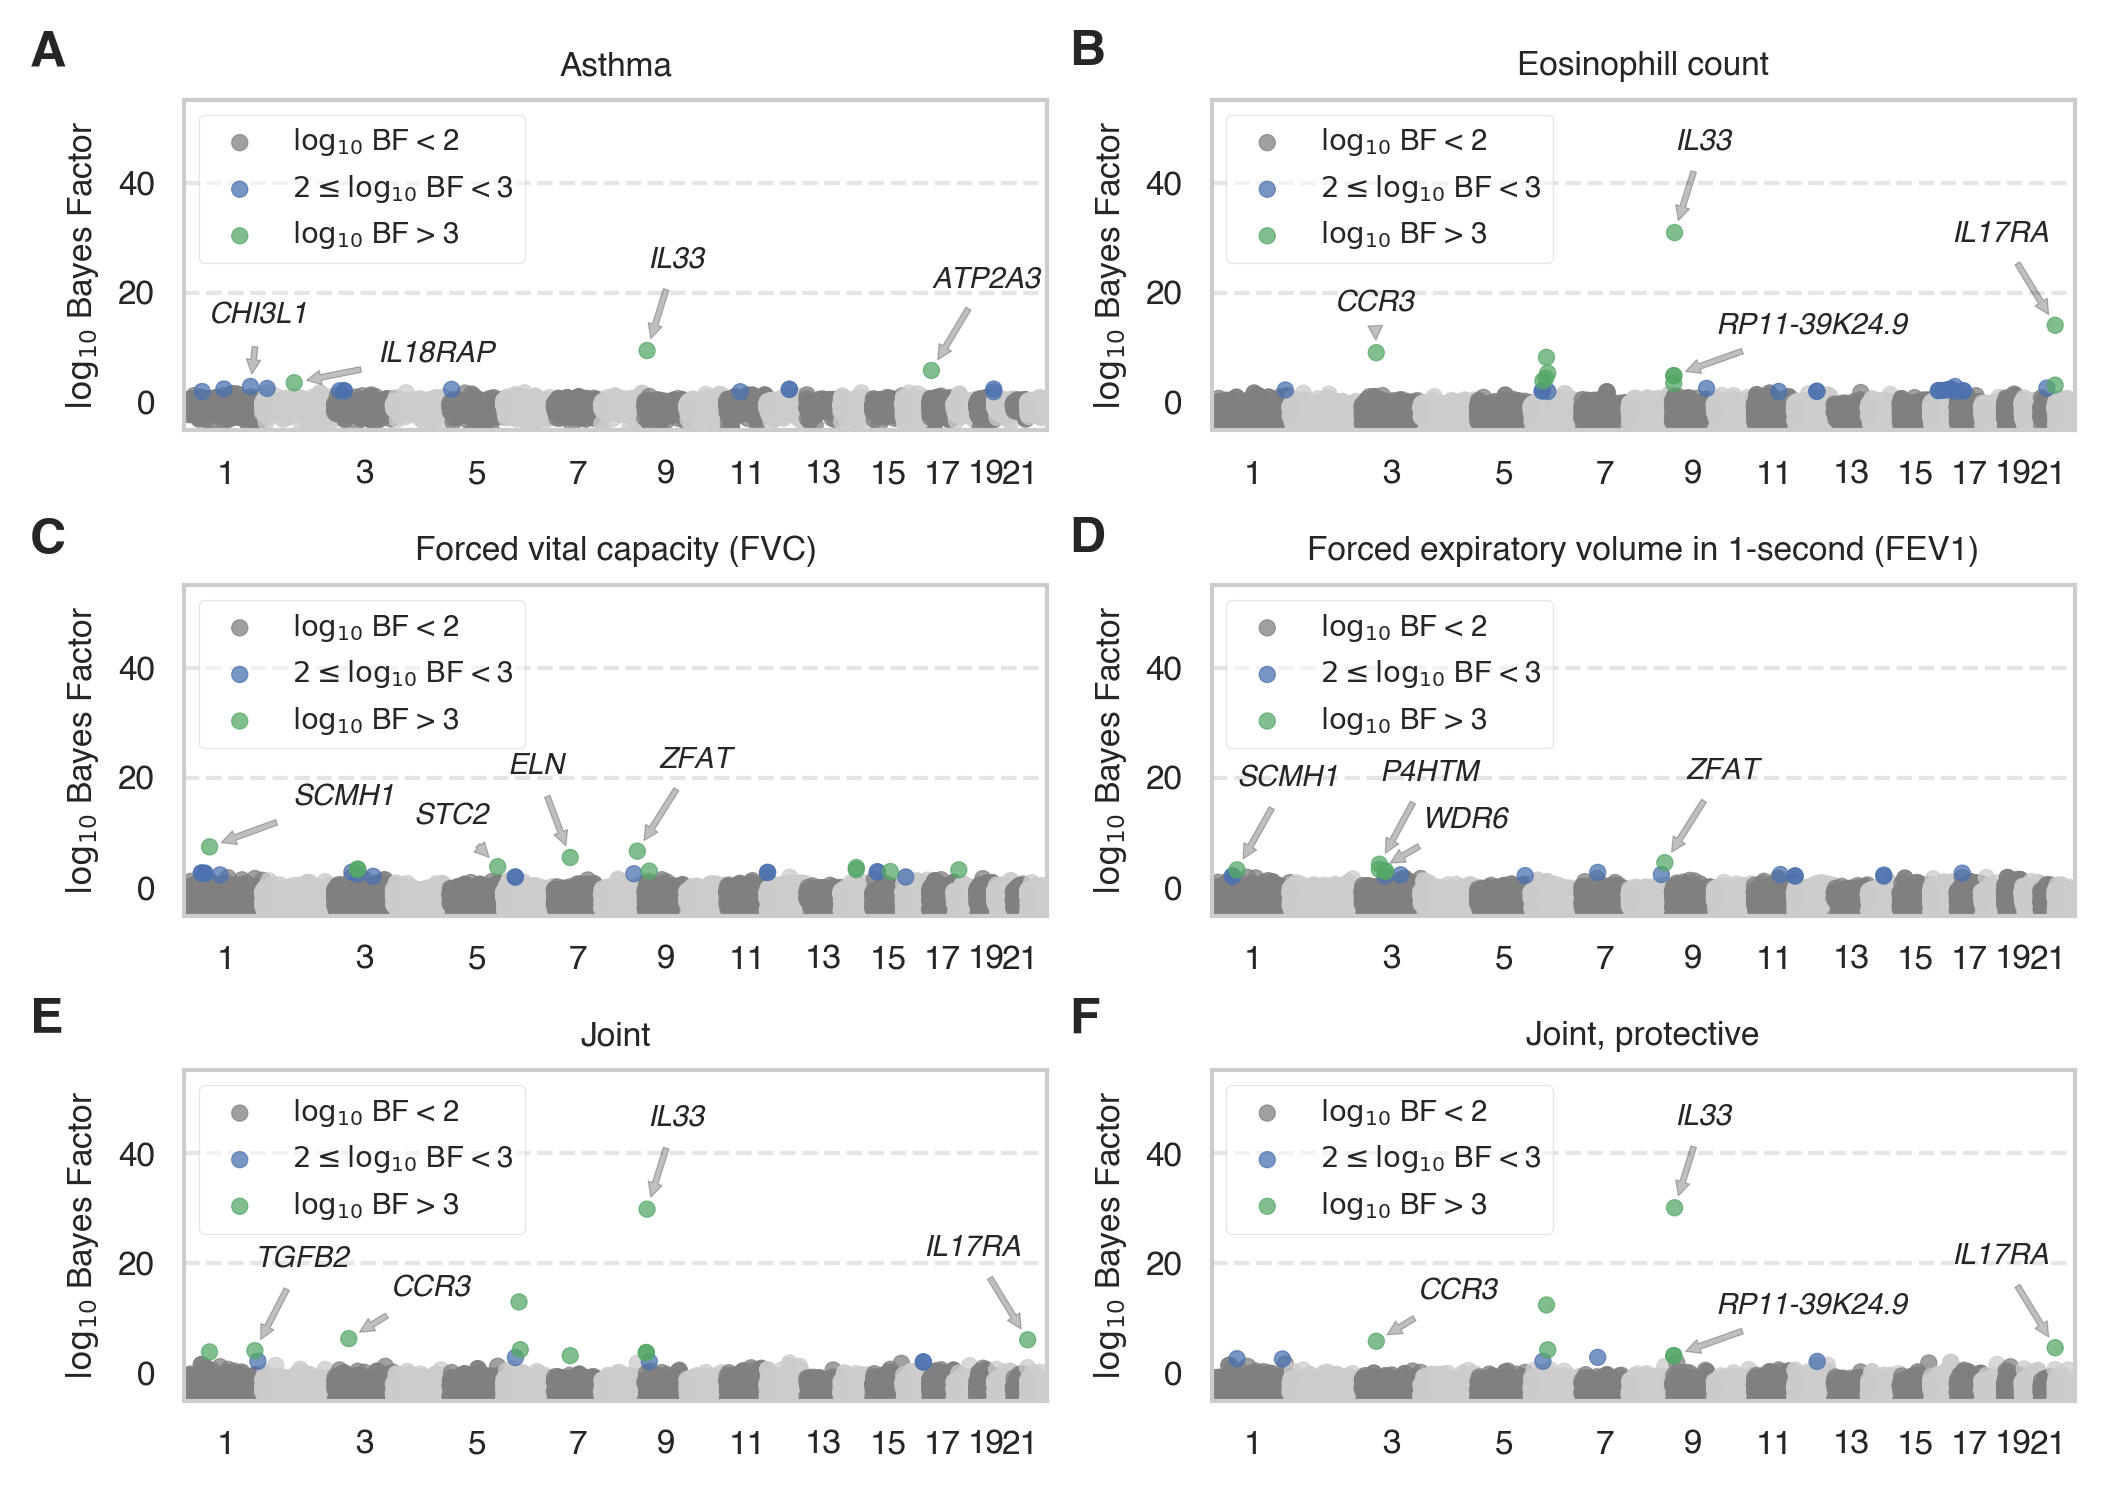

In [9]:
annotations = dict()
for fn in glob.glob('../results/asthma/*out'):
    annotations[fn] = get_annotations(fn)

fig = plt.figure(figsize=(7, 5), dpi=300)
# gs = gridspec.GridSpec(1, 1)
# ax = fig.add_subplot(gs[0, 0])
# ax.text(0, 1, 'Figure 2',
#         size=14, va='top')
# clean_axis(ax)
# gs.tight_layout(fig, rect=[0, 0.93, 1, 1])

gs = gridspec.GridSpec(3, 2)
axs = []

# A
ax = fig.add_subplot(gs[0, 0])
fn = '../results/asthma/f4traits.asthma.chrpos.01_00001.out'
ax,res = plot_manhattan(fn, ax)
ax.set_ylim(-5, 55)
offsets = {'IL33':(0, 20), 'ATP2A3':(0, 20), 'IL18RAP':(20, 5), 'CHI3L1':(-10, 15)}
add_annotations(fn, ax, offsets)
title = phenos.loc['HC382', 'phenotype'].replace('_', ' ')
title = title[0].upper() + title[1:]
ax.set_title(title, fontsize=8)
axs.append(ax)

# B
ax = fig.add_subplot(gs[0, 1])
fn = '../results/asthma/f4traits.eosinophil.chrpos.01_00001.out'
ax,res = plot_manhattan(fn, ax)
ax.set_ylim(-5, 55)
offsets = {'IL33':(0, 20), 'CCR3':(-10, 10), 'IL17RA':(-25, 20), 'CTD-3064M3.3':(0, 20)}
add_annotations(fn, ax, offsets)
title = phenos.loc['INI30150', 'phenotype'].replace('_', ' ')
title = title[0].upper() + title[1:]
ax.set_title(title, fontsize=8)
axs.append(ax)

# C
ax = fig.add_subplot(gs[1, 0])
fn = '../results/asthma/f4traits.fvc.chrpos.01_00001.out'
ax,res = plot_manhattan(fn, ax)
ax.set_ylim(-5, 55)
offsets = {'ZFAT':(5, 20), 'SCMH1':(20, 10), 'STC2':(-20, 10), 'ELN':(-15, 20)}
add_annotations(fn, ax, offsets)
title = phenos.loc['INI3062', 'phenotype'].replace('_', ' ')
title = title[0].upper() + title[1:]
ax.set_title(title, fontsize=8)
axs.append(ax)

# D
ax = fig.add_subplot(gs[1, 1])
fn = '../results/asthma/f4traits.fev.chrpos.01_00001.out'
ax,res = plot_manhattan(fn, ax)
ax.set_ylim(-5, 55)
offsets = {'ZFAT':(5, 20), 'P4HTM':(-10, 10), 'ZFAT-AS1':(20, 10), 'TMEM110':(-5, 20),
           'SCMH1':(0, 20), 'WDR6':(10, 10), 'P4HTM':(0, 20)}
add_annotations(fn, ax, offsets)
title = phenos.loc['INI3063', 'phenotype'].replace('_', ' ')
title = title[0].upper() + title[1:]
ax.set_title(title, fontsize=8)
axs.append(ax)

# E 
ax = fig.add_subplot(gs[2, 0])
fn = '../results/asthma/f4traits.all.asthma.chrpos.01_00001.out'
ax,res = plot_manhattan(fn, ax)
ax.set_ylim(-5, 55)
# ymin,ymax = ax.get_ylim()
# for a in axs:
#     a.set_ylim(ymin, ymax)
offsets = {'IL33':(0, 20), 'ZFAT':(-50, 5), 'CSF2RB':(-30, 25), 'GPR20':(30, 5),
           'TGFB2':(0, 20), 'IL17RA':(-25, 20)}
add_annotations(fn, ax, offsets)
ax.set_title('Joint', fontsize=8)

# F
ax = fig.add_subplot(gs[2, 1])
fn = '../results/asthma/f4traits.prot.asthma.chrpos.01_00001.out'
ax,res = plot_manhattan(fn, ax)
ax.set_ylim(-5, 55)
# ymin,ymax = ax.get_ylim()
# for a in axs:
#     a.set_ylim(ymin, ymax)
offsets = {'IL33':(0, 20), 'ZFAT':(-50, 5), 'CSF2RB':(-30, 25), 'GPR20':(30, 5),
           'IL17RA':(-25, 20)}
add_annotations(fn, ax, offsets)
ax.set_title('Joint, protective', fontsize=8)

t = fig.text(0.005, 0.96, 'A', weight='bold', 
             size=12)
t = fig.text(0.5, 0.96, 'B', weight='bold', 
             size=12)
t = fig.text(0.005, 0.635, 'C', weight='bold', 
             size=12)
t = fig.text(0.5, 0.635, 'D', weight='bold', 
             size=12)
t = fig.text(0.005, 0.315, 'E', weight='bold', 
             size=12)
t = fig.text(0.5, 0.315, 'F', weight='bold', 
             size=12)

gs.tight_layout(fig, rect=[0, 0, 1, 1])
plt.savefig('asthma_manhattan_l10bf.pdf')

l10bf2


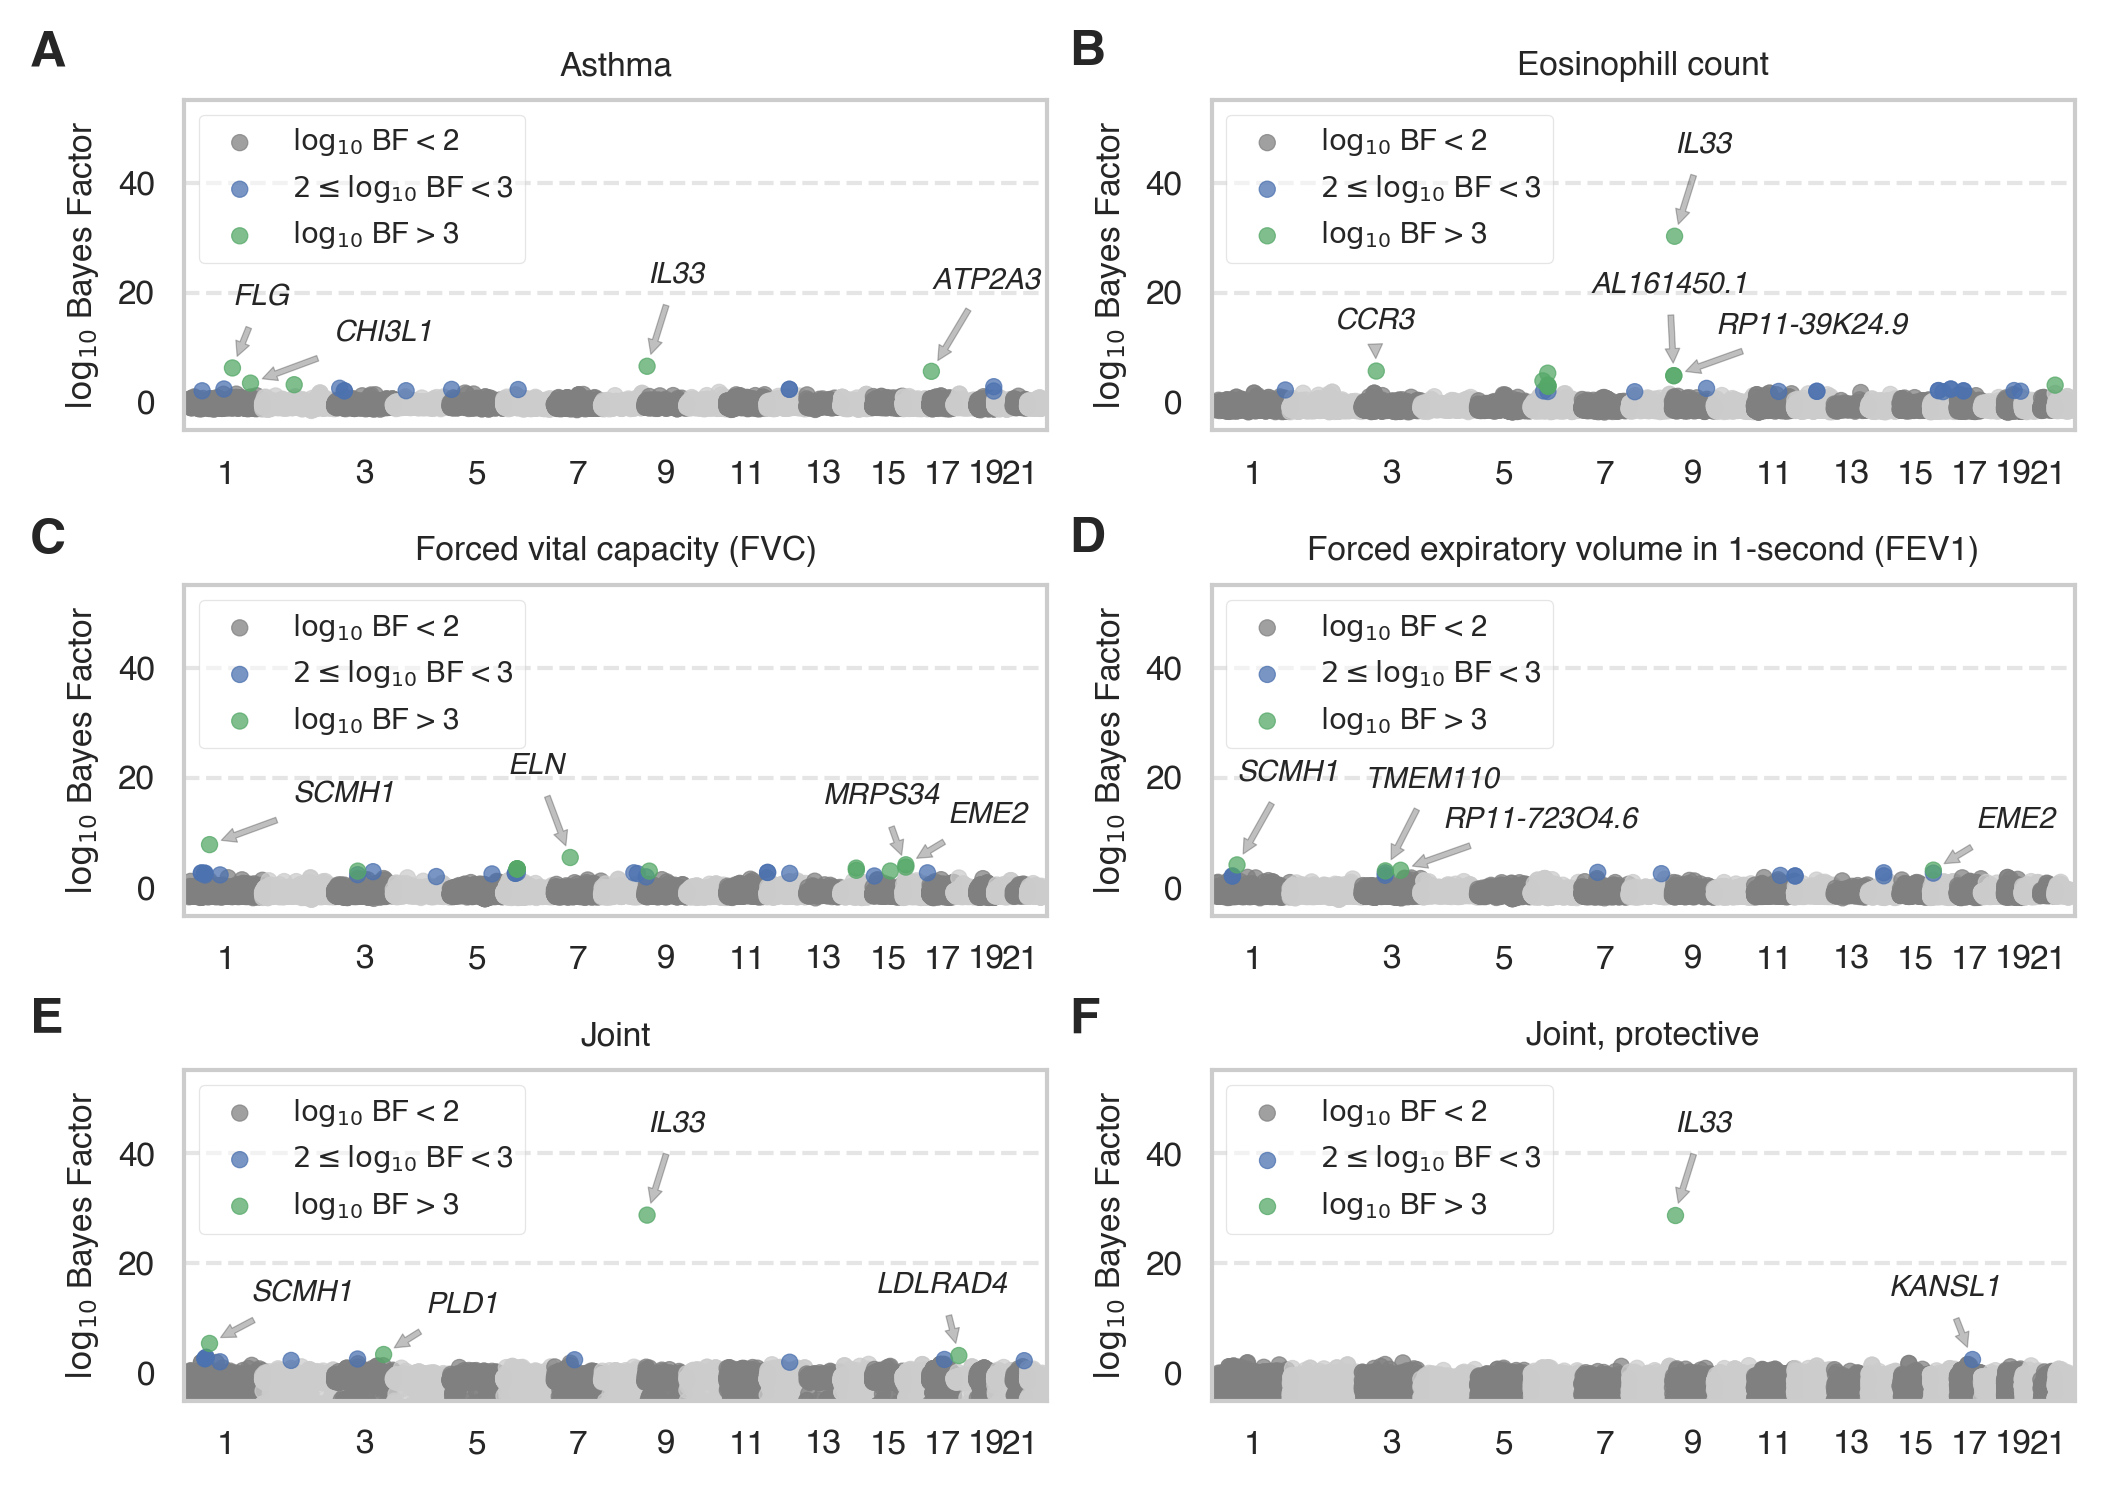

In [10]:
col = 'l10bf2'
print(col)
annotations = dict()
for fn in glob.glob('../results/asthma/*out'):
    annotations[fn] = get_annotations(fn, col=col)

fig = plt.figure(figsize=(7, 5), dpi=300)
# gs = gridspec.GridSpec(1, 1)
# ax = fig.add_subplot(gs[0, 0])
# ax.text(0, 1, 'Figure 2',
#         size=14, va='top')
# clean_axis(ax)
# gs.tight_layout(fig, rect=[0, 0.93, 1, 1])

gs = gridspec.GridSpec(3, 2)
axs = []

# A
ax = fig.add_subplot(gs[0, 0])
fn = '../results/asthma/f4traits.asthma.chrpos.01_00001.out'
ax,res = plot_manhattan(fn, ax, col=col)
ax.set_ylim(-5, 55)
offsets = {'IL33':(0, 20), 'ATP2A3':(0, 20), 'IL18RAP':(20, 5), 'CHI3L1':(-10, 15),
           'FLG':(0, 15), 'CHI3L1':(20, 10)}
add_annotations(fn, ax, offsets, col=col)
title = phenos.loc['HC382', 'phenotype'].replace('_', ' ')
title = title[0].upper() + title[1:]
ax.set_title(title, fontsize=8)
axs.append(ax)

# B
ax = fig.add_subplot(gs[0, 1])
fn = '../results/asthma/f4traits.eosinophil.chrpos.01_00001.out'
ax,res = plot_manhattan(fn, ax, col=col)
ax.set_ylim(-5, 55)
offsets = {'IL33':(0, 20), 'CCR3':(-10, 10), 'IL17RA':(-25, 20), 'CTD-3064M3.3':(0, 20),
           'AL161450.1':(-20, 20)}
add_annotations(fn, ax, offsets, col=col)
title = phenos.loc['INI30150', 'phenotype'].replace('_', ' ')
title = title[0].upper() + title[1:]
ax.set_title(title, fontsize=8)
axs.append(ax)

# C
ax = fig.add_subplot(gs[1, 0])
fn = '../results/asthma/f4traits.fvc.chrpos.01_00001.out'
ax,res = plot_manhattan(fn, ax, col=col)
ax.set_ylim(-5, 55)
offsets = {'ZFAT':(5, 20), 'SCMH1':(20, 10), 'STC2':(-20, 10), 'ELN':(-15, 20),
           'MRPS34':(-20, 15)}
add_annotations(fn, ax, offsets, col=col)
title = phenos.loc['INI3062', 'phenotype'].replace('_', ' ')
title = title[0].upper() + title[1:]
ax.set_title(title, fontsize=8)
axs.append(ax)

# D
ax = fig.add_subplot(gs[1, 1])
fn = '../results/asthma/f4traits.fev.chrpos.01_00001.out'
ax,res = plot_manhattan(fn, ax, col=col)
ax.set_ylim(-5, 55)
offsets = {'ZFAT':(5, 20), 'P4HTM':(-10, 10), 'ZFAT-AS1':(20, 10), 'TMEM110':(-5, 20),
           'SCMH1':(0, 20), 'WDR6':(10, 10), 'P4HTM':(0, 20)}
add_annotations(fn, ax, offsets, col=col)
title = phenos.loc['INI3063', 'phenotype'].replace('_', ' ')
title = title[0].upper() + title[1:]
ax.set_title(title, fontsize=8)
axs.append(ax)

# E 
ax = fig.add_subplot(gs[2, 0])
fn = '../results/asthma/f4traits.all.asthma.chrpos.01_00001.out'
ax,res = plot_manhattan(fn, ax, col=col)
ax.set_ylim(-5, 55)
# ymin,ymax = ax.get_ylim()
# for a in axs:
#     a.set_ylim(ymin, ymax)
offsets = {'IL33':(0, 20), 'ZFAT':(-50, 5), 'CSF2RB':(-30, 25), 'GPR20':(30, 5),
           'TGFB2':(0, 20), 'IL17RA':(-25, 20), 'LDLRAD4':(-20, 15)}
add_annotations(fn, ax, offsets, col=col)
ax.set_title('Joint', fontsize=8)

# F
ax = fig.add_subplot(gs[2, 1])
fn = '../results/asthma/f4traits.prot.asthma.chrpos.01_00001.out'
ax,res = plot_manhattan(fn, ax, col=col)
ax.set_ylim(-5, 55)
# ymin,ymax = ax.get_ylim()
# for a in axs:
#     a.set_ylim(ymin, ymax)
offsets = {'IL33':(0, 20), 'ZFAT':(-50, 5), 'CSF2RB':(-30, 25), 'GPR20':(30, 5),
           'IL17RA':(-25, 20), 'KANSL1':(-20, 15)}
add_annotations(fn, ax, offsets, col=col)
ax.set_title('Joint, protective', fontsize=8)

t = fig.text(0.005, 0.96, 'A', weight='bold', 
             size=12)
t = fig.text(0.5, 0.96, 'B', weight='bold', 
             size=12)
t = fig.text(0.005, 0.635, 'C', weight='bold', 
             size=12)
t = fig.text(0.5, 0.635, 'D', weight='bold', 
             size=12)
t = fig.text(0.005, 0.315, 'E', weight='bold', 
             size=12)
t = fig.text(0.5, 0.315, 'F', weight='bold', 
             size=12)

gs.tight_layout(fig, rect=[0, 0, 1, 1])
plt.savefig('asthma_manhattan_{}.pdf'.format(col))

bma


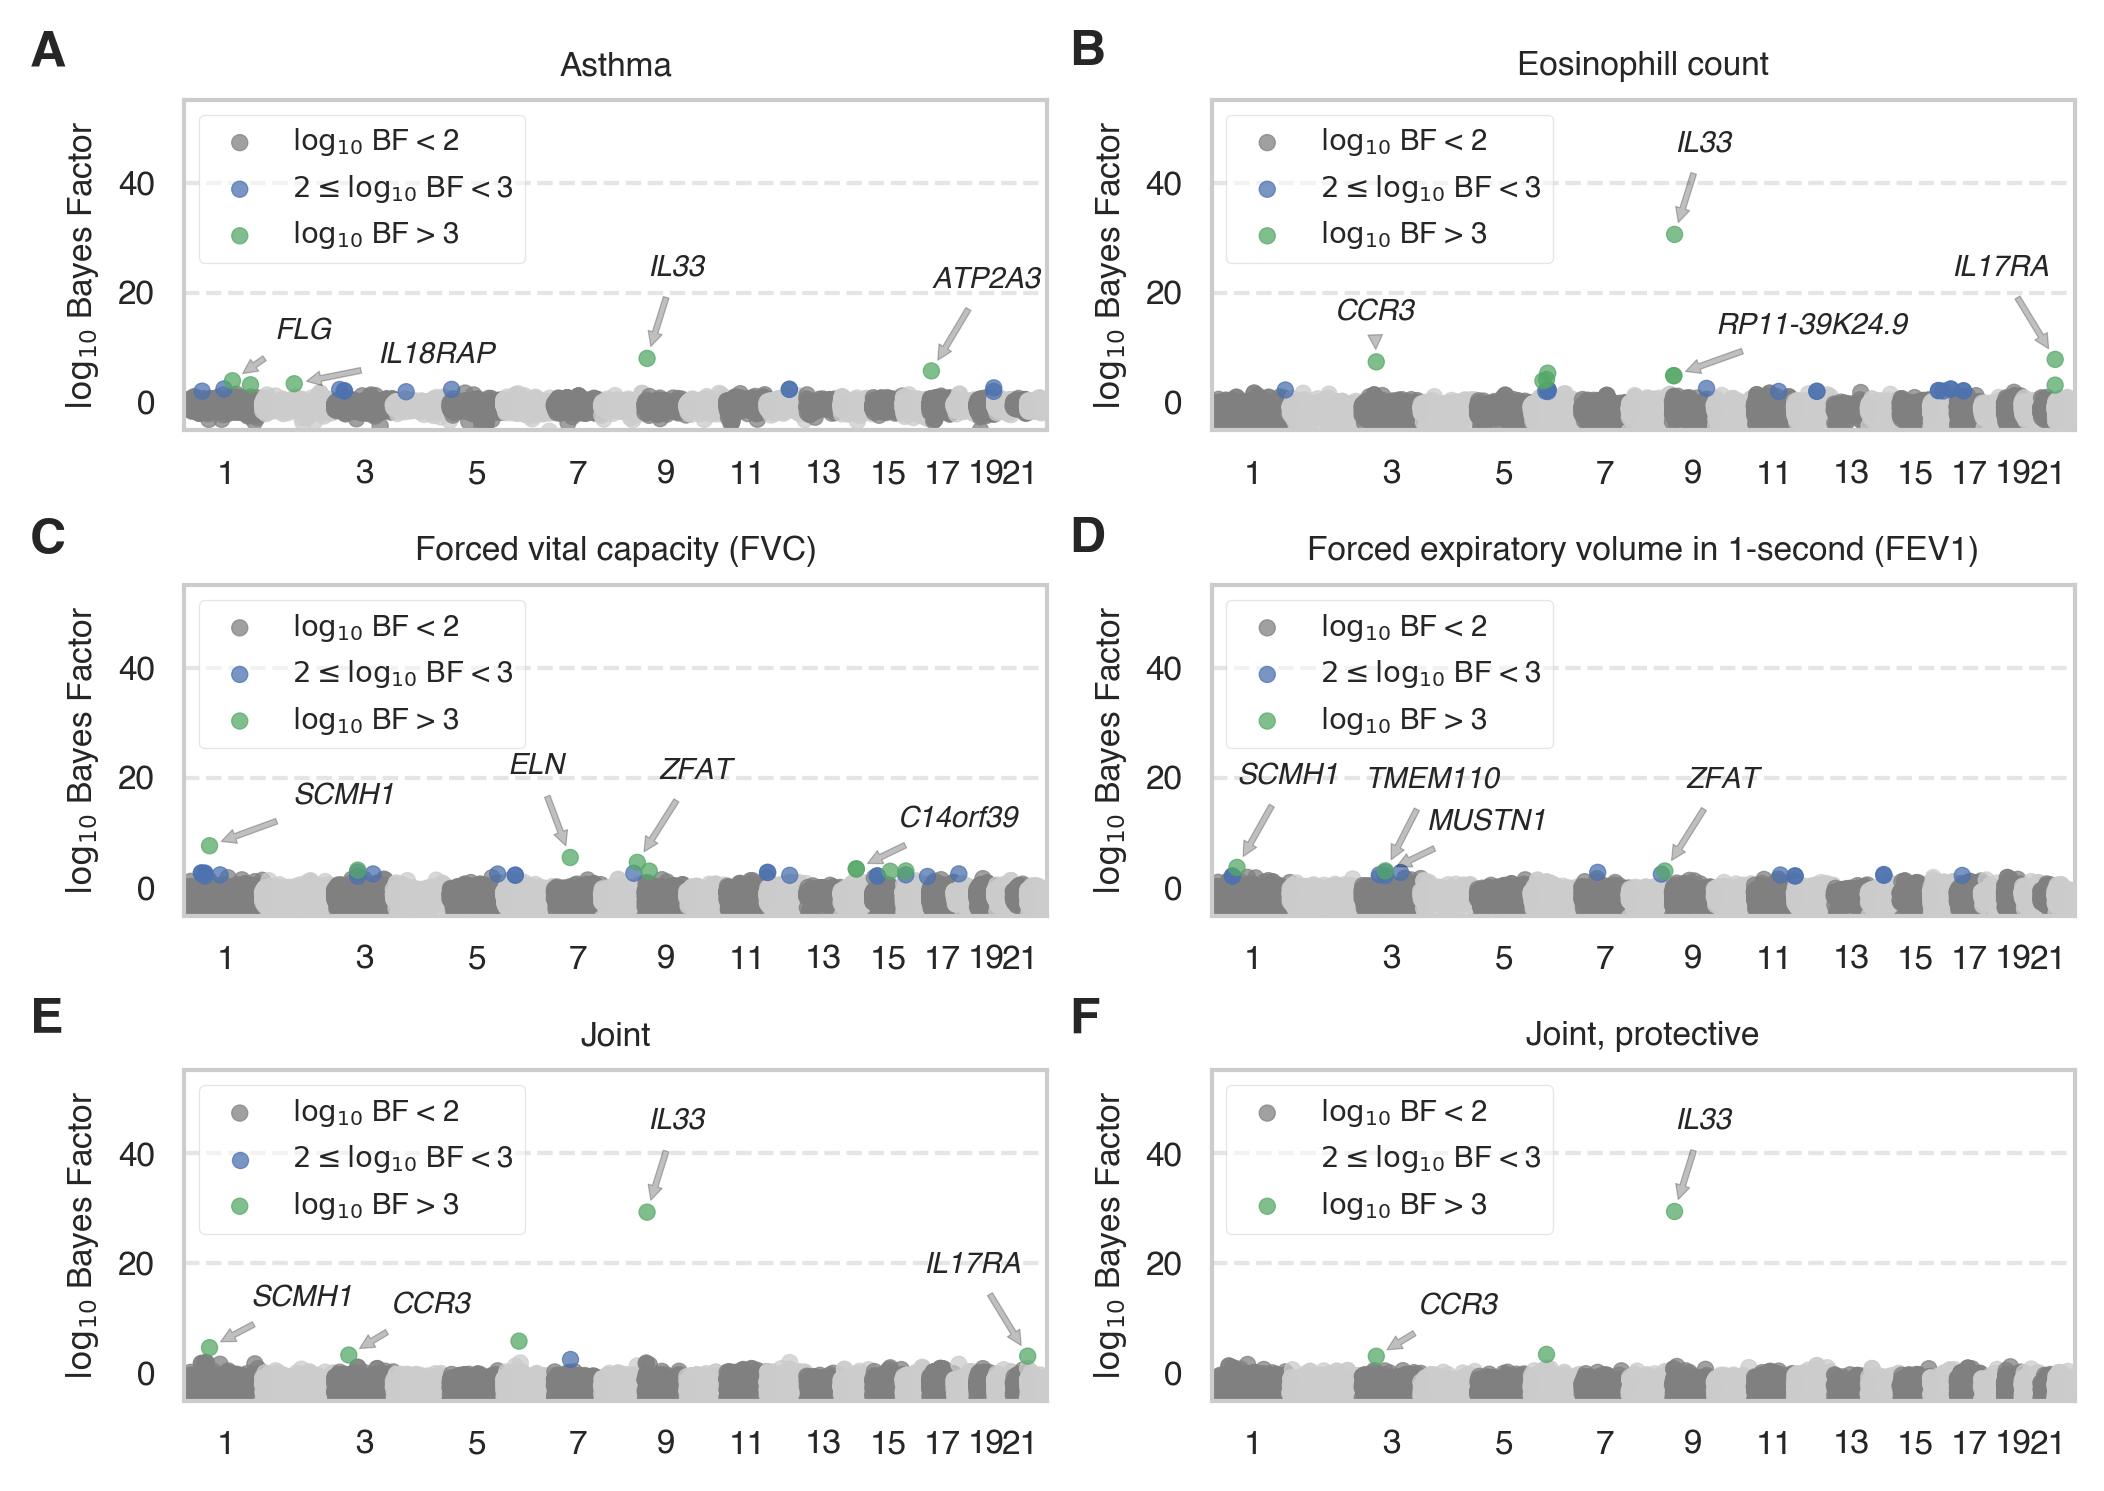

In [11]:
col = 'bma'
print(col)
annotations = dict()
for fn in glob.glob('../results/asthma/*out'):
    annotations[fn] = get_annotations(fn, col=col)

fig = plt.figure(figsize=(7, 5), dpi=300)
# gs = gridspec.GridSpec(1, 1)
# ax = fig.add_subplot(gs[0, 0])
# ax.text(0, 1, 'Figure 2',
#         size=14, va='top')
# clean_axis(ax)
# gs.tight_layout(fig, rect=[0, 0.93, 1, 1])

gs = gridspec.GridSpec(3, 2)
axs = []

# A
ax = fig.add_subplot(gs[0, 0])
fn = '../results/asthma/f4traits.asthma.chrpos.01_00001.out'
ax,res = plot_manhattan(fn, ax, col=col)
ax.set_ylim(-5, 55)
offsets = {'IL33':(0, 20), 'ATP2A3':(0, 20), 'IL18RAP':(20, 5), 'CHI3L1':(-10, 15)}
add_annotations(fn, ax, offsets, col=col)
title = phenos.loc['HC382', 'phenotype'].replace('_', ' ')
title = title[0].upper() + title[1:]
ax.set_title(title, fontsize=8)
axs.append(ax)

# B
ax = fig.add_subplot(gs[0, 1])
fn = '../results/asthma/f4traits.eosinophil.chrpos.01_00001.out'
ax,res = plot_manhattan(fn, ax, col=col)
ax.set_ylim(-5, 55)
offsets = {'IL33':(0, 20), 'CCR3':(-10, 10), 'IL17RA':(-25, 20), 'CTD-3064M3.3':(0, 20)}
add_annotations(fn, ax, offsets, col=col)
title = phenos.loc['INI30150', 'phenotype'].replace('_', ' ')
title = title[0].upper() + title[1:]
ax.set_title(title, fontsize=8)
axs.append(ax)

# C
ax = fig.add_subplot(gs[1, 0])
fn = '../results/asthma/f4traits.fvc.chrpos.01_00001.out'
ax,res = plot_manhattan(fn, ax, col=col)
ax.set_ylim(-5, 55)
offsets = {'ZFAT':(5, 20), 'SCMH1':(20, 10), 'STC2':(-20, 10), 'ELN':(-15, 20)}
add_annotations(fn, ax, offsets, col=col)
title = phenos.loc['INI3062', 'phenotype'].replace('_', ' ')
title = title[0].upper() + title[1:]
ax.set_title(title, fontsize=8)
axs.append(ax)

# D
ax = fig.add_subplot(gs[1, 1])
fn = '../results/asthma/f4traits.fev.chrpos.01_00001.out'
ax,res = plot_manhattan(fn, ax, col=col)
ax.set_ylim(-5, 55)
offsets = {'ZFAT':(5, 20), 'P4HTM':(-10, 10), 'ZFAT-AS1':(20, 10), 'TMEM110':(-5, 20),
           'SCMH1':(0, 20), 'WDR6':(10, 10), 'P4HTM':(0, 20)}
add_annotations(fn, ax, offsets, col=col)
title = phenos.loc['INI3063', 'phenotype'].replace('_', ' ')
title = title[0].upper() + title[1:]
ax.set_title(title, fontsize=8)
axs.append(ax)

# E 
ax = fig.add_subplot(gs[2, 0])
fn = '../results/asthma/f4traits.all.asthma.chrpos.01_00001.out'
ax,res = plot_manhattan(fn, ax, col=col)
ax.set_ylim(-5, 55)
# ymin,ymax = ax.get_ylim()
# for a in axs:
#     a.set_ylim(ymin, ymax)
offsets = {'IL33':(0, 20), 'ZFAT':(-50, 5), 'CSF2RB':(-30, 25), 'GPR20':(30, 5),
           'TGFB2':(0, 20), 'IL17RA':(-25, 20)}
add_annotations(fn, ax, offsets, col=col)
ax.set_title('Joint', fontsize=8)

# F
ax = fig.add_subplot(gs[2, 1])
fn = '../results/asthma/f4traits.prot.asthma.chrpos.01_00001.out'
ax,res = plot_manhattan(fn, ax, col=col)
ax.set_ylim(-5, 55)
# ymin,ymax = ax.get_ylim()
# for a in axs:
#     a.set_ylim(ymin, ymax)
offsets = {'IL33':(0, 20), 'ZFAT':(-50, 5), 'CSF2RB':(-30, 25), 'GPR20':(30, 5),
           'IL17RA':(-25, 20)}
add_annotations(fn, ax, offsets, col=col)
ax.set_title('Joint, protective', fontsize=8)

t = fig.text(0.005, 0.96, 'A', weight='bold', 
             size=12)
t = fig.text(0.5, 0.96, 'B', weight='bold', 
             size=12)
t = fig.text(0.005, 0.635, 'C', weight='bold', 
             size=12)
t = fig.text(0.5, 0.635, 'D', weight='bold', 
             size=12)
t = fig.text(0.005, 0.315, 'E', weight='bold', 
             size=12)
t = fig.text(0.5, 0.315, 'F', weight='bold', 
             size=12)

gs.tight_layout(fig, rect=[0, 0, 1, 1])
plt.savefig('asthma_manhattan_{}.pdf'.format(col))

In [12]:
results = dict()

fn = '../results/asthma/f4traits.eosinophil.chrpos.01_00001.out'
tdf = read_results(fn)
tdf = tdf.sort_values(by='l10bf', ascending=False)
results['Eosinophil count'] = tdf

fn = '../results/asthma/f4traits.fvc.chrpos.01_00001.out'
tdf = read_results(fn)
tdf = tdf.sort_values(by='l10bf', ascending=False)
results['FVC'] = tdf

fn = '../results/asthma/f4traits.fev.chrpos.01_00001.out'
tdf = read_results(fn)
tdf = tdf.sort_values(by='l10bf', ascending=False)
results['FEV1'] = tdf

fn = '../results/asthma/f4traits.asthma.chrpos.01_00001.out'
tdf = read_results(fn)
tdf = tdf.sort_values(by='l10bf', ascending=False)
results['Asthma'] = tdf

fn = '../results/asthma/f4traits.prot.asthma.chrpos.01_00001.out'
tdf = read_results(fn)
tdf = tdf.sort_values(by='l10bf', ascending=False)
results['Joint, protective'] = tdf

fn = '../results/asthma/f4traits.all.asthma.chrpos.01_00001.out'
tdf = read_results(fn)
tdf = tdf.sort_values(by='l10bf', ascending=False)
results['Joint'] = tdf

results_pd = pd.Panel(results)

In [13]:
# table_index = tdf[(tdf['l10bf'] > 5) & (tdf['chrom'] != 6)].index
table_index = set()
for k in annotations.keys():
    table_index |= set(annotations[k])
table = results_pd.loc[:, table_index, 'bma']
table = table.sort_values(by='Joint, protective', ascending=False)
table = table.fillna(1000).round(1).astype(str).replace('1000.0', '')
table = table[['Joint, protective', 'Joint', 'Eosinophil count', 'FVC', 'FEV1', 'Asthma']]
print(table)

             Joint, protective  Joint Eosinophil count   FVC  FEV1 Asthma
IL33                      29.4   29.3             30.6  -2.3  -2.2    8.1
CCR3                       3.1    3.3              7.4  -1.4  -1.6   -0.5
RP11-39K24.9               0.8    1.8              4.9  -0.1  -0.4    0.3
SCMH1                      0.5    4.7             -1.5   7.7   3.8   -0.7
MUSTN1                     0.4    1.1             -1.2   2.9   2.9   -0.6
ZFAT                       0.3    1.3             -2.0   4.7   3.1   -0.4
ELN                        0.2    2.5             -1.0   5.6   2.9   -0.6
C14orf39                  -0.7   -0.0             -1.1   3.5   2.5    0.0
TMEM110                   -0.9    1.1             -1.0   3.3   3.1   -0.6
IL17RA                    -4.4    3.1              7.9  -2.7  -2.5   -1.1
IL18RAP                   -9.6   -0.9             -1.0  -1.6  -1.7    3.5
ATP2A3                   -11.9   -0.8             -1.2  -2.1  -2.2    5.8
FLG                      -20.1  -17.2 

In [14]:
print(table.to_latex())

\begin{tabular}{lllllll}
\toprule
{} & Joint, protective &  Joint & Eosinophil count &   FVC &  FEV1 & Asthma \\
\midrule
IL33         &              29.4 &   29.3 &             30.6 &  -2.3 &  -2.2 &    8.1 \\
CCR3         &               3.1 &    3.3 &              7.4 &  -1.4 &  -1.6 &   -0.5 \\
RP11-39K24.9 &               0.8 &    1.8 &              4.9 &  -0.1 &  -0.4 &    0.3 \\
SCMH1        &               0.5 &    4.7 &             -1.5 &   7.7 &   3.8 &   -0.7 \\
MUSTN1       &               0.4 &    1.1 &             -1.2 &   2.9 &   2.9 &   -0.6 \\
ZFAT         &               0.3 &    1.3 &             -2.0 &   4.7 &   3.1 &   -0.4 \\
ELN          &               0.2 &    2.5 &             -1.0 &   5.6 &   2.9 &   -0.6 \\
C14orf39     &              -0.7 &   -0.0 &             -1.1 &   3.5 &   2.5 &    0.0 \\
TMEM110      &              -0.9 &    1.1 &             -1.0 &   3.3 &   3.1 &   -0.6 \\
IL17RA       &              -4.4 &    3.1 &              7.9 &  -2.7 &  -2.5 

### Forest Plot

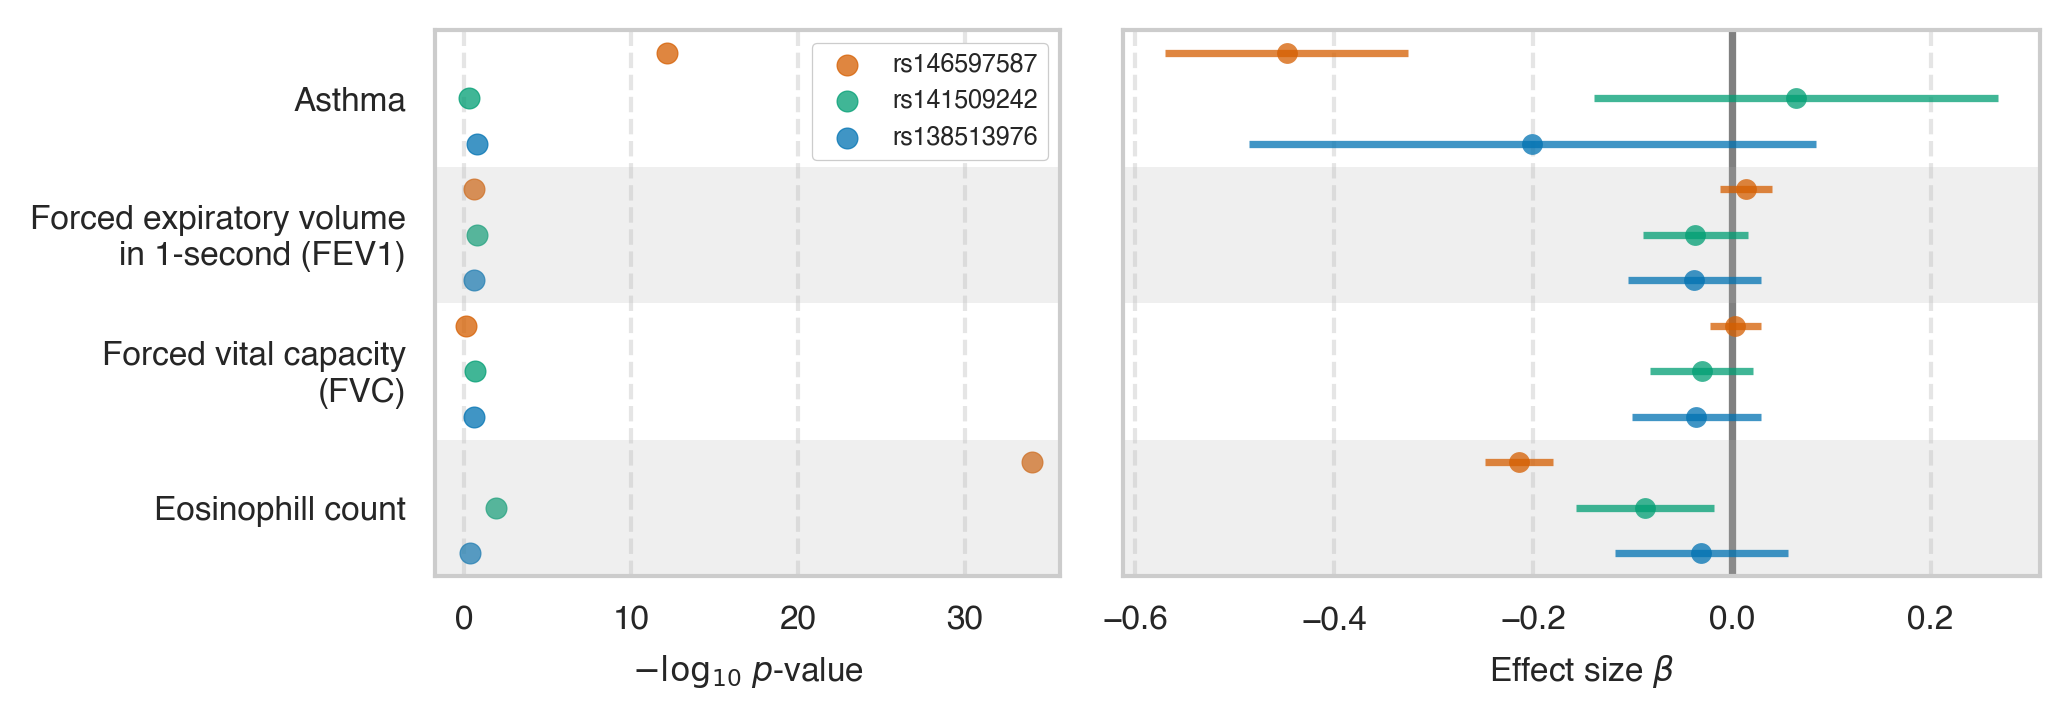

In [15]:
ps = ['INI30150', 'INI3062', 'INI3063', 'HC382']
gwas_res = {}
for p in ps:
    gwas_res[p] = make_stan_input_files.get_results(p)
    gwas_res[p] = gwas_res[p].loc[varinfo['ID']]
    gwas_res[p]['beta_upper'] = gwas_res[p]['BETA'] + 1.96 * gwas_res[p]['SE']
    gwas_res[p]['beta_lower'] = gwas_res[p]['BETA'] - 1.96 * gwas_res[p]['SE']
gwas_res = pd.Panel(gwas_res)

il33 = gene_info[gene_info.gene_name == 'IL33'].index[0]
variants = list(varinfo_f.loc[(varinfo_f.Gene == il33) & 
                              (varinfo_f['maf'] > 0.0005) &
                              (varinfo_f['maf'] < 0.01) &
                              (varinfo_f['all_filters'] == 0),
                              'ID'])

fig = plt.figure(figsize=(7, 2.5), dpi=300)
gs = gridspec.GridSpec(1, 2, width_ratios=[1.5, 2.2])

forest_plot(ps, variants, gs)

gs.tight_layout(fig, rect=[0, 0, 1, 1], w_pad=1)
plt.savefig('asthma_forest.pdf')

/home/groups/mrivas/software/anaconda2_sherlock2/envs/h2-estimation/lib/python2.7/site-packages/matplotlib/gridspec.py:306: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


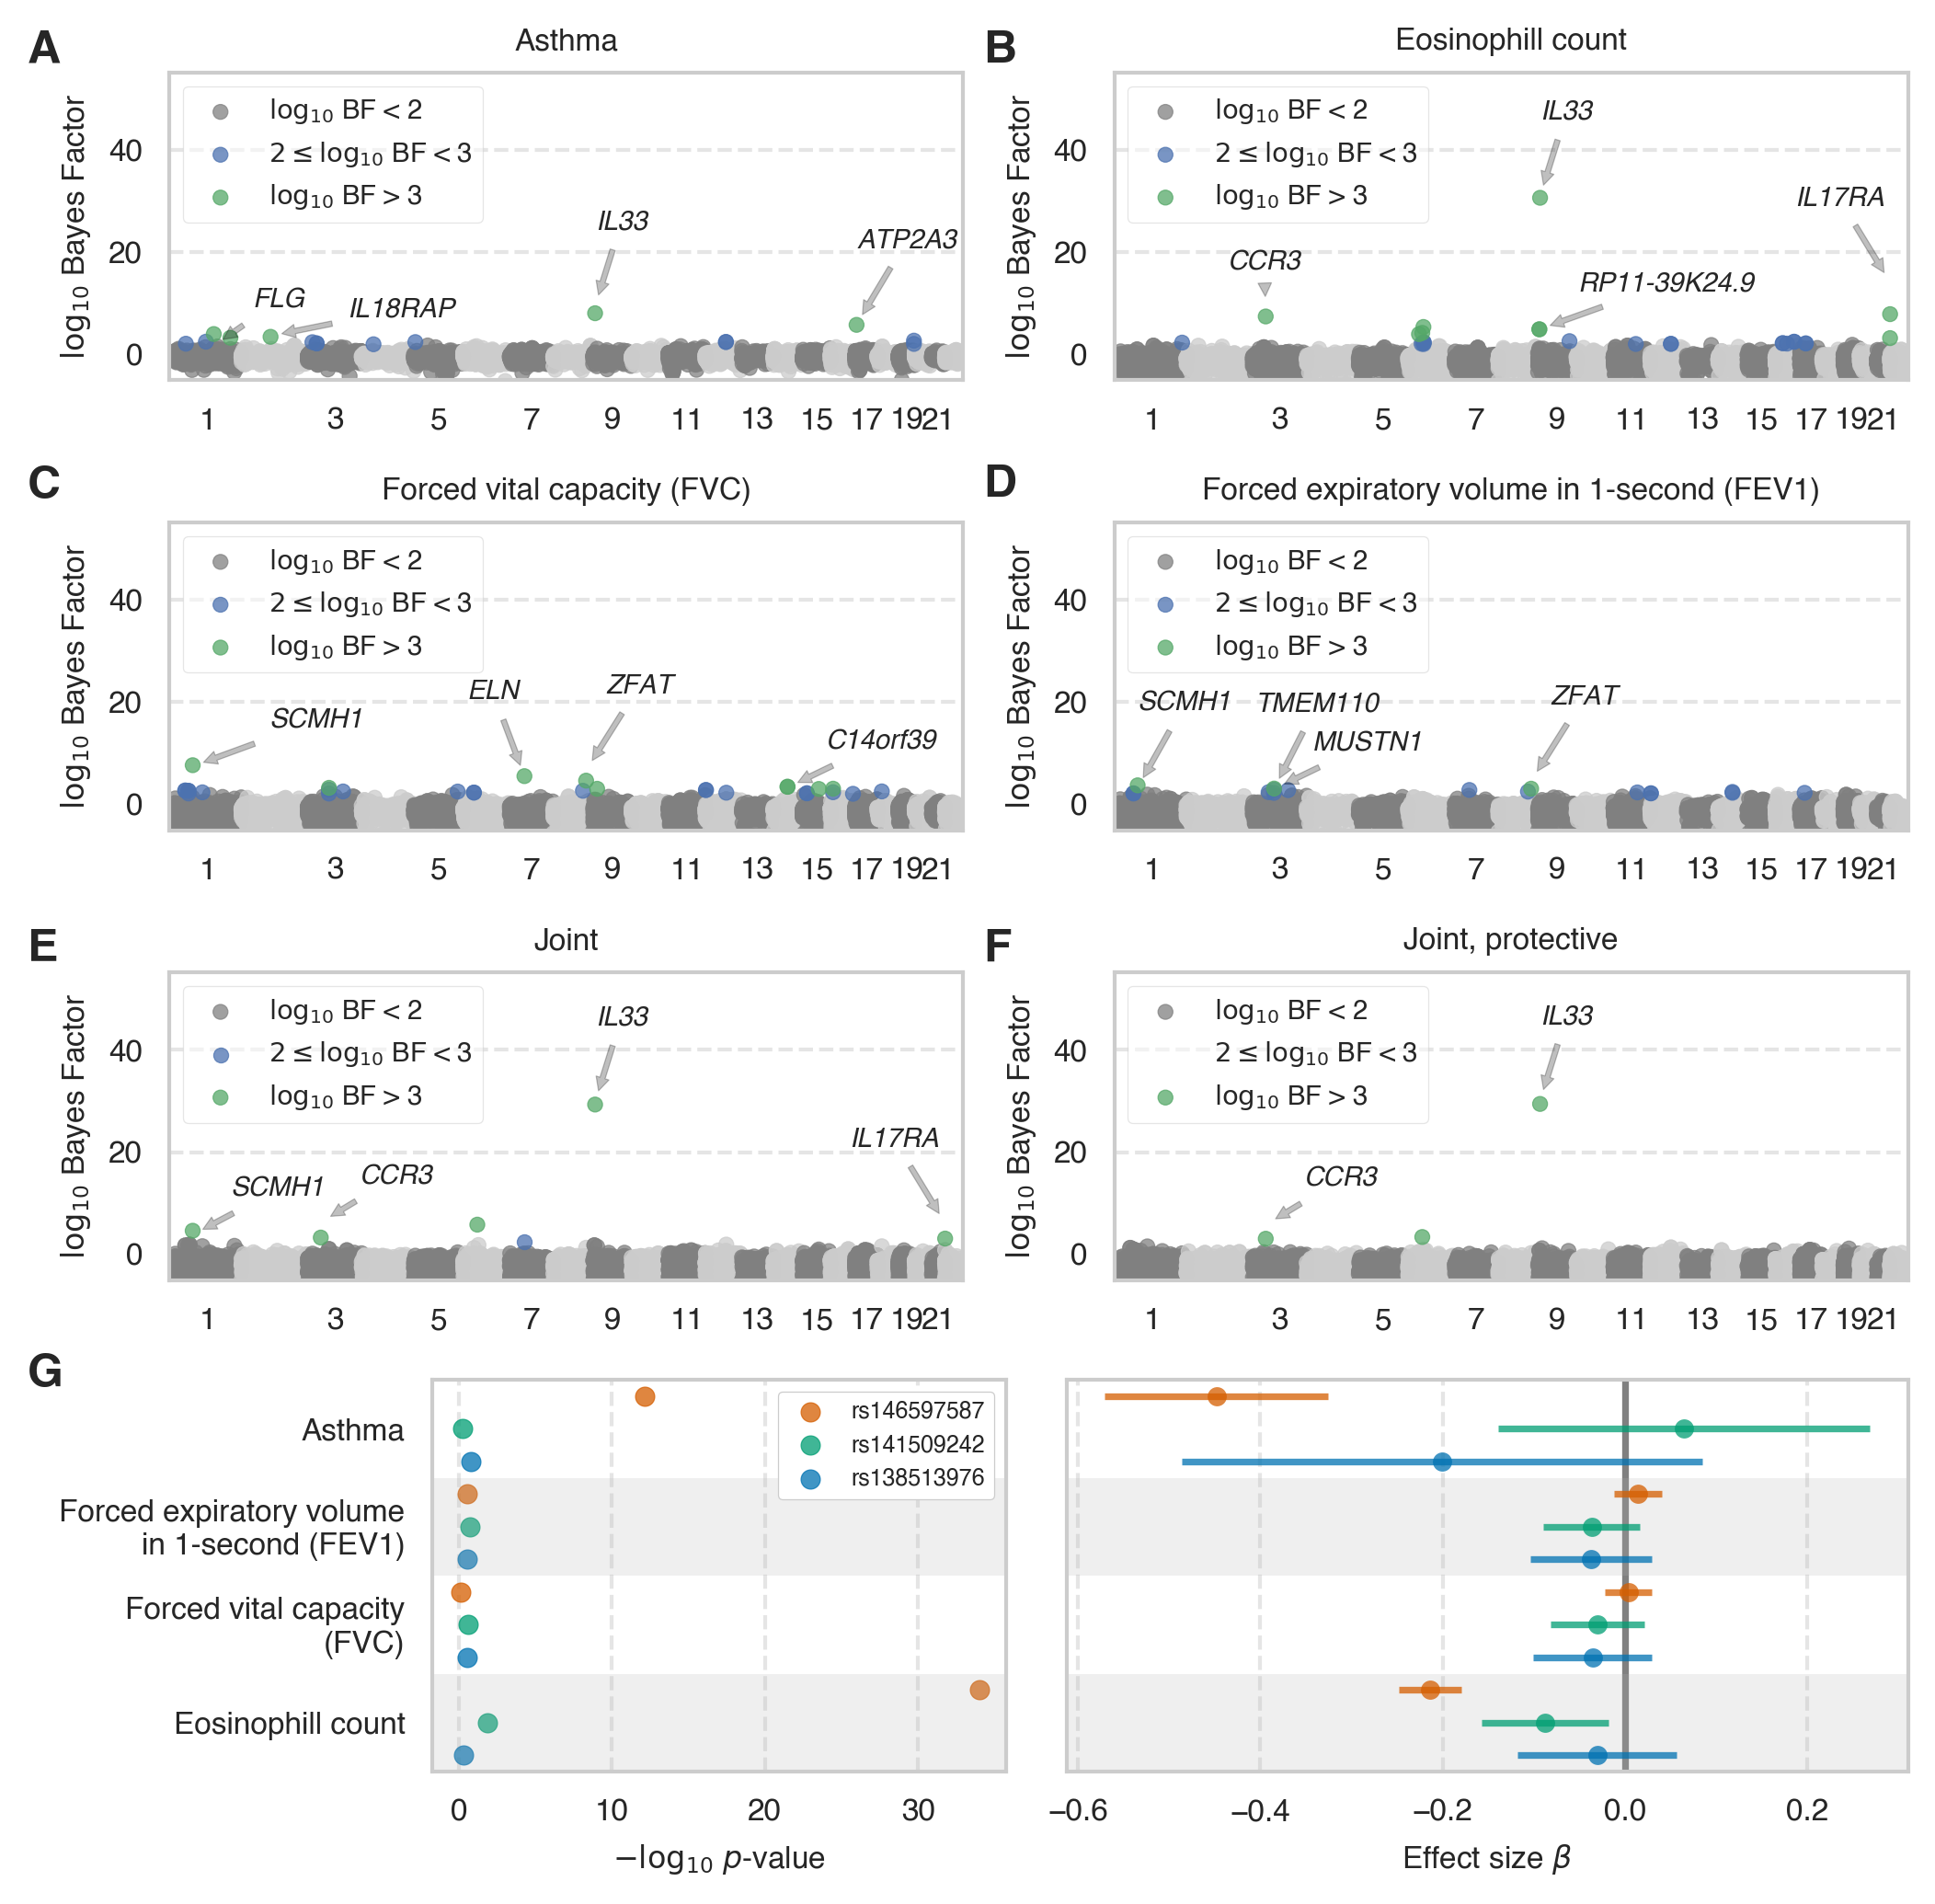

In [16]:
col = 'bma'
annotations = dict()
for fn in glob.glob('../results/asthma/*out'):
    annotations[fn] = get_annotations(fn, col=col)

fig = plt.figure(figsize=(7, 7), dpi=300)
# gs = gridspec.GridSpec(1, 1)
# ax = fig.add_subplot(gs[0, 0])
# ax.text(0, 1, 'Figure 2',
#         size=14, va='top')
# clean_axis(ax)
# gs.tight_layout(fig, rect=[0, 0.93, 1, 1])

gs = gridspec.GridSpec(3, 2)
axs = []

# A
ax = fig.add_subplot(gs[0, 0])
fn = '../results/asthma/f4traits.asthma.chrpos.01_00001.out'
ax,res = plot_manhattan(fn, ax, col=col)
ax.set_ylim(-5, 55)
offsets = {'IL33':(0, 20), 'ATP2A3':(0, 20), 'IL18RAP':(20, 5), 'CHI3L1':(-10, 15)}
add_annotations(fn, ax, offsets)
title = phenos.loc['HC382', 'phenotype'].replace('_', ' ')
title = title[0].upper() + title[1:]
ax.set_title(title, fontsize=8)
axs.append(ax)

# B
ax = fig.add_subplot(gs[0, 1])
fn = '../results/asthma/f4traits.eosinophil.chrpos.01_00001.out'
ax,res = plot_manhattan(fn, ax, col=col)
ax.set_ylim(-5, 55)
offsets = {'IL33':(0, 20), 'CCR3':(-10, 10), 'IL17RA':(-25, 20), 'CTD-3064M3.3':(0, 20)}
add_annotations(fn, ax, offsets)
title = phenos.loc['INI30150', 'phenotype'].replace('_', ' ')
title = title[0].upper() + title[1:]
ax.set_title(title, fontsize=8)
axs.append(ax)

# C
ax = fig.add_subplot(gs[1, 0])
fn = '../results/asthma/f4traits.fvc.chrpos.01_00001.out'
ax,res = plot_manhattan(fn, ax, col=col)
ax.set_ylim(-5, 55)
offsets = {'ZFAT':(5, 20), 'SCMH1':(20, 10), 'STC2':(-20, 10), 'ELN':(-15, 20)}
add_annotations(fn, ax, offsets)
title = phenos.loc['INI3062', 'phenotype'].replace('_', ' ')
title = title[0].upper() + title[1:]
ax.set_title(title, fontsize=8)
axs.append(ax)

# D
ax = fig.add_subplot(gs[1, 1])
fn = '../results/asthma/f4traits.fev.chrpos.01_00001.out'
ax,res = plot_manhattan(fn, ax, col=col)
ax.set_ylim(-5, 55)
offsets = {'ZFAT':(5, 20), 'P4HTM':(-10, 10), 'ZFAT-AS1':(20, 10), 'TMEM110':(-5, 20),
           'SCMH1':(0, 20), 'WDR6':(10, 10), 'P4HTM':(0, 20)}
add_annotations(fn, ax, offsets)
title = phenos.loc['INI3063', 'phenotype'].replace('_', ' ')
title = title[0].upper() + title[1:]
ax.set_title(title, fontsize=8)
axs.append(ax)

# E 
ax = fig.add_subplot(gs[2, 0])
fn = '../results/asthma/f4traits.all.asthma.chrpos.01_00001.out'
ax,res = plot_manhattan(fn, ax, col=col)
ax.set_ylim(-5, 55)
# ymin,ymax = ax.get_ylim()
# for a in axs:
#     a.set_ylim(ymin, ymax)
offsets = {'IL33':(0, 20), 'ZFAT':(-50, 5), 'CSF2RB':(-30, 25), 'GPR20':(30, 5),
           'TGFB2':(0, 20), 'IL17RA':(-25, 20)}
add_annotations(fn, ax, offsets)
ax.set_title('Joint', fontsize=8)

# F
ax = fig.add_subplot(gs[2, 1])
fn = '../results/asthma/f4traits.prot.asthma.chrpos.01_00001.out'
ax,res = plot_manhattan(fn, ax, col=col)
ax.set_ylim(-5, 55)
# ymin,ymax = ax.get_ylim()
# for a in axs:
#     a.set_ylim(ymin, ymax)
offsets = {'IL33':(0, 20), 'ZFAT':(-50, 5), 'CSF2RB':(-30, 25), 'GPR20':(30, 5),
           'IL17RA':(-25, 20)}
add_annotations(fn, ax, offsets)
ax.set_title('Joint, protective', fontsize=8)

gs.tight_layout(fig, rect=[0, 0.28, 1, 1])

# G
gs = gridspec.GridSpec(1, 2, width_ratios=[1.5, 2.2])
out = forest_plot(ps, variants, gs)
gs.tight_layout(fig, rect=[0, 0, 1, 0.3])

t = fig.text(0.005, 0.96, 'A', weight='bold', 
             size=12)
t = fig.text(0.5, 0.96, 'B', weight='bold', 
             size=12)
t = fig.text(0.005, 0.735, 'C', weight='bold', 
             size=12)
t = fig.text(0.5, 0.735, 'D', weight='bold', 
             size=12)
t = fig.text(0.005, 0.495, 'E', weight='bold', 
             size=12)
t = fig.text(0.5, 0.495, 'F', weight='bold', 
             size=12)
t = fig.text(0.005, 0.275, 'G', weight='bold', 
             size=12)

plt.savefig('asthma_combined_{}.pdf'.format(col))

## Glaucoma

### Manhattan

l10bf


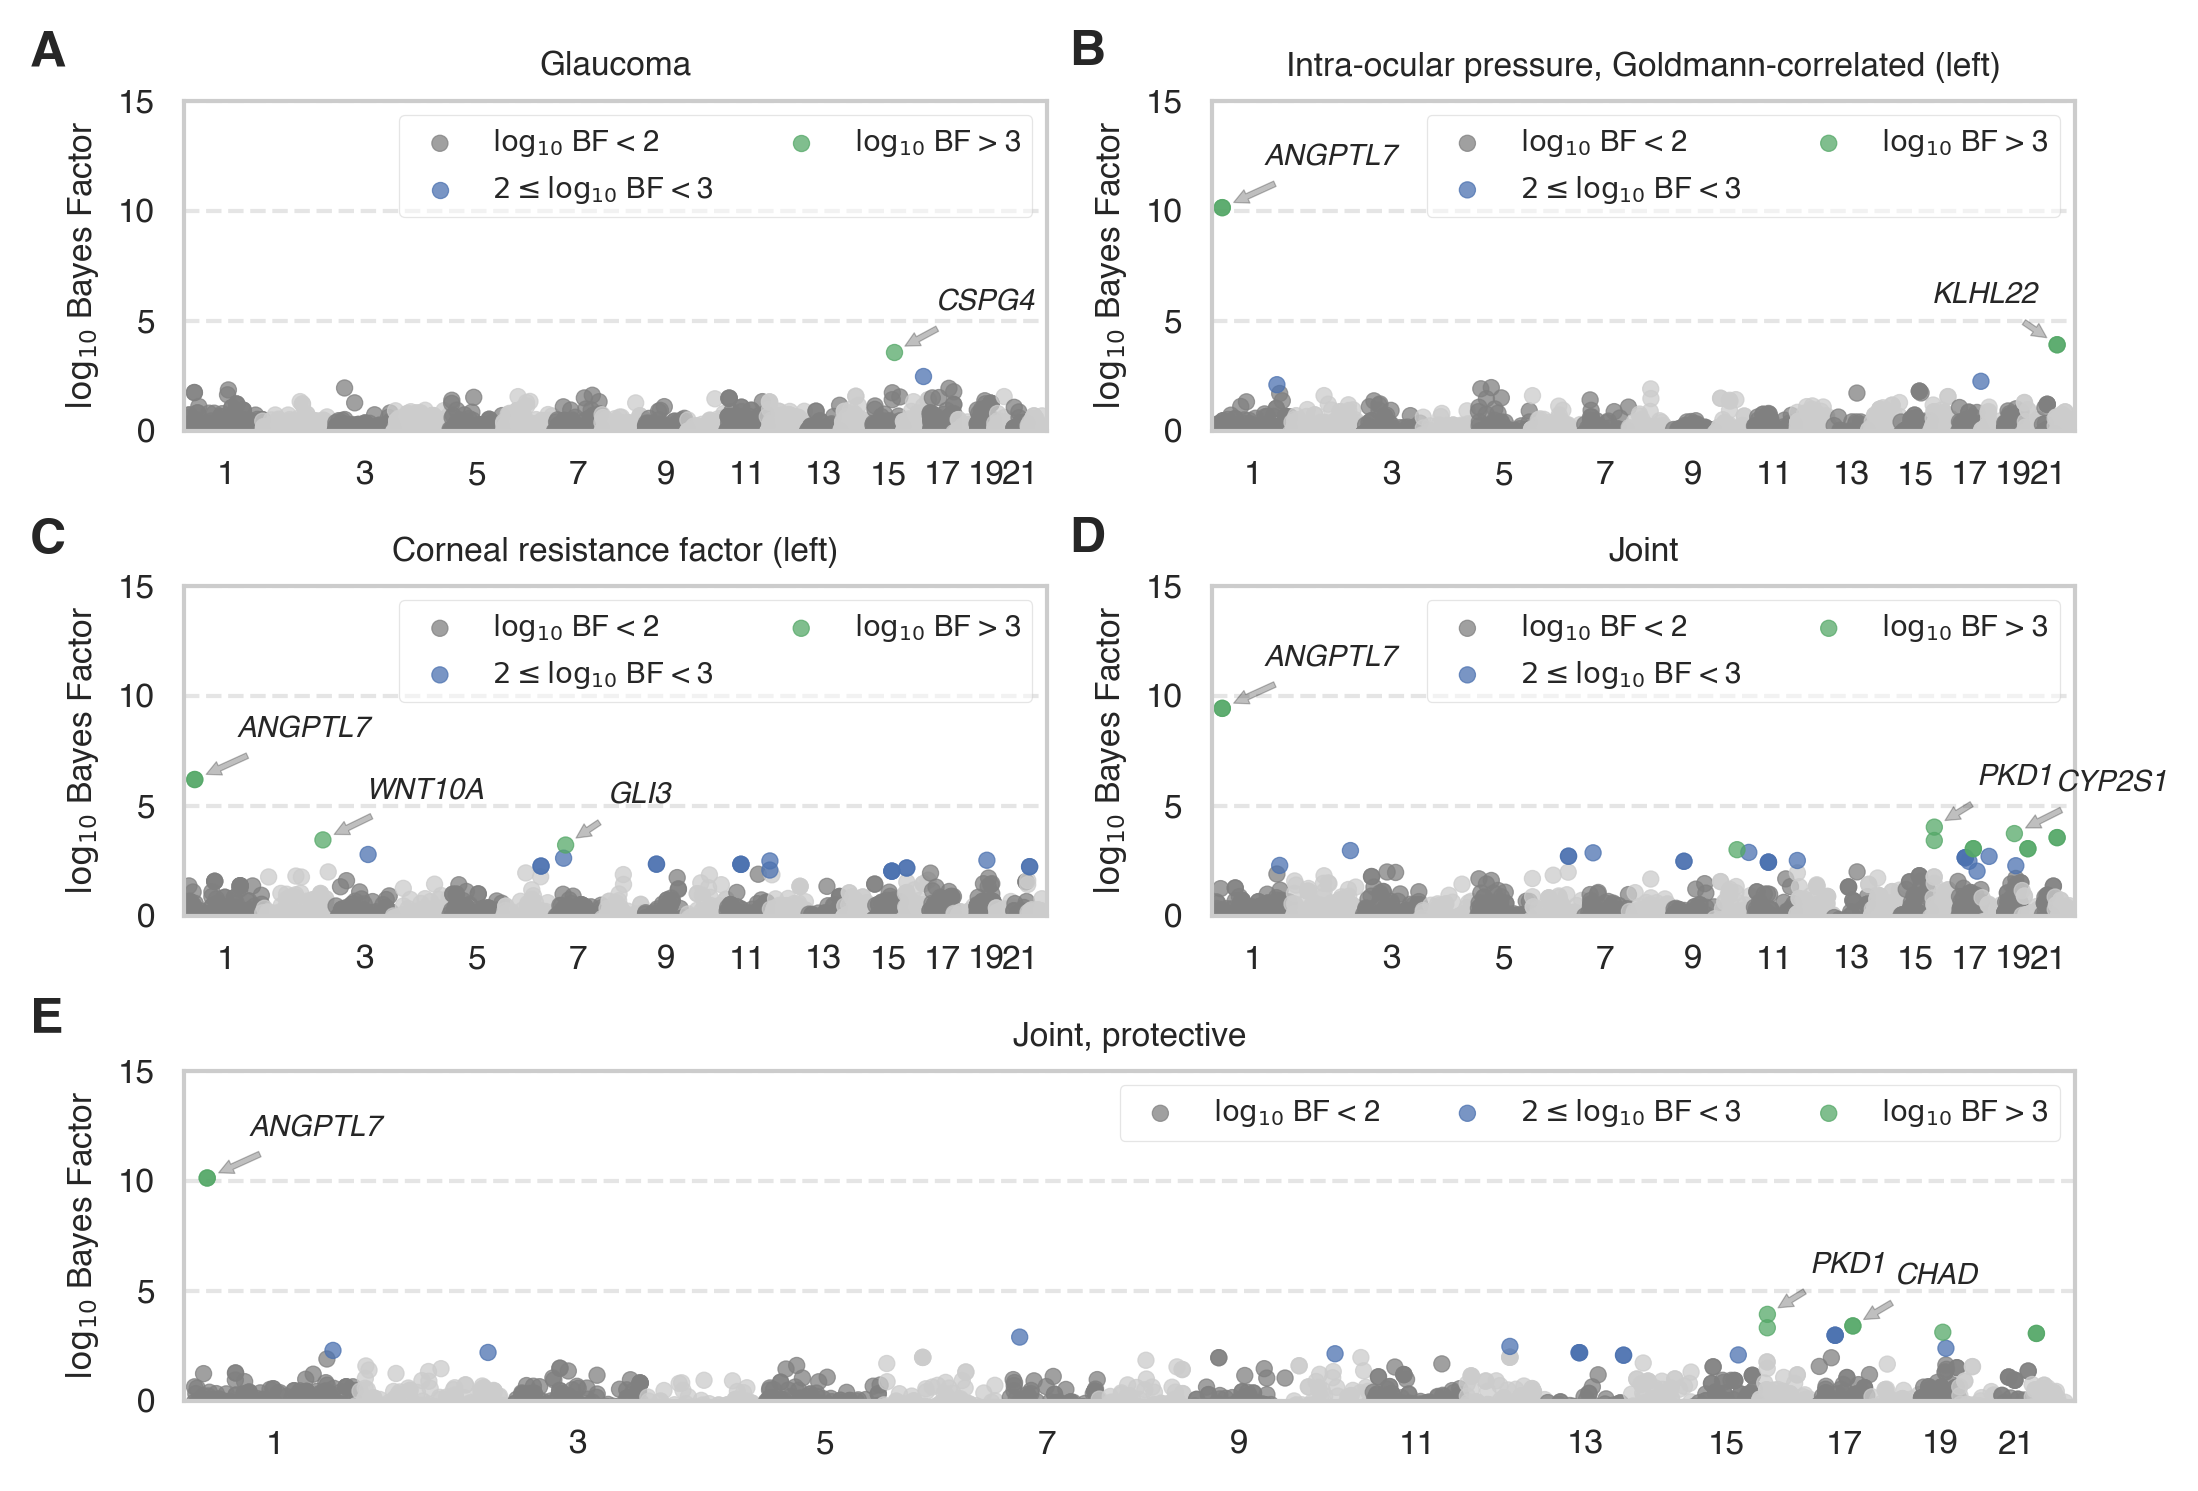

In [18]:
col = 'l10bf'
print(col)

annotations = dict()
for fn in [
    '../results/glaucoma/HC276.glaucoma.chrpos.01_00001.out',
    '../results/glaucoma/INI5263.glaucoma.chrpos.01_00001.out',
    '../results/glaucoma/INI5265.glaucoma.chrpos.01_00001.out',
    '../results/glaucoma/f4traits.all.glaucoma.chrpos.01_00001.out',
    '../results/glaucoma/f4traits.prot.glaucoma.chrpos.01_00001.out',
]:
    annotations[fn] = list(get_annotations(fn, cutoff=3, col=col))
    if 'ANGPTL7' in annotations[fn] and 'MTOR' in annotations[fn]:
        annotations[fn].remove('MTOR')
    if 'SCARF2' in annotations[fn] and 'KLHL22' in annotations[fn]:
        annotations[fn].remove('SCARF2')
    tdf = read_results(fn)

fig = plt.figure(figsize=(7, 5), dpi=300)
# gs = gridspec.GridSpec(1, 1)
# ax = fig.add_subplot(gs[0, 0])
# ax.text(0, 1, 'Figure 2',
#         size=14, va='top')
# clean_axis(ax)
# gs.tight_layout(fig, rect=[0, 0.93, 1, 1])

gs = gridspec.GridSpec(3, 2)
axs = []
ax = fig.add_subplot(gs[0, 0])
fn = '../results/glaucoma/HC276.glaucoma.chrpos.01_00001.out'
ax,res = plot_manhattan(fn, ax, col=col, loc='upper right', ncol=2)
ax.set_ylim(0, 15)
# offsets = {'IL33':(0, 20), 'CCR3':(0, 10), 'IL17RA':(-25, 20), 'CTD-3064M3.3':(0, 20)}
offsets = dict(zip(annotations[fn], [[10, 10] for x in annotations[fn]]))
add_annotations(fn, ax, offsets, col=col)
title = phenos.loc['HC276', 'phenotype'].replace('_', ' ')
title = title[0].upper() + title[1:]
ax.set_title(title, fontsize=8)
axs.append(ax)

ax = fig.add_subplot(gs[0, 1])
fn = '../results/glaucoma/INI5263.glaucoma.chrpos.01_00001.out'
ax,res = plot_manhattan(fn, ax, col=col, loc='upper right', ncol=2)
ax.set_ylim(0, 15)
offsets = {'ANGPTL7':(10, 10), 'KLHL22':(-30, 10)}
add_annotations(fn, ax, offsets, col=col)
title = phenos.loc['INI5263', 'phenotype'].replace('_', ' ')
title = title[0].upper() + title[1:]
ax.set_title(title, fontsize=8)
axs.append(ax)

ax = fig.add_subplot(gs[1, 0])
fn = '../results/glaucoma/INI5265.glaucoma.chrpos.01_00001.out'
ax,res = plot_manhattan(fn, ax, col=col, loc='upper right', ncol=2)
ax.set_ylim(0, 15)
offsets = dict(zip(annotations[fn], [[10, 10] for x in annotations[fn]]))
add_annotations(fn, ax, offsets, col=col)
title = phenos.loc['INI5265', 'phenotype'].replace('_', ' ')
title = title[0].upper() + title[1:]
ax.set_title(title, fontsize=8)
axs.append(ax)

ax = fig.add_subplot(gs[1, 1])
fn = '../results/glaucoma/f4traits.all.glaucoma.chrpos.01_00001.out'
ax,res = plot_manhattan(fn, ax, col=col, loc='upper right', ncol=2)
ax.set_ylim(0, 15)
offsets = {'ANGPTL7':(10, 10), 'WNT10A':(10, 10), 'KLHL22':(-30, 10)}
add_annotations(fn, ax, offsets, col=col)
ax.set_title('Joint', fontsize=8)
axs.append(ax)

ax = fig.add_subplot(gs[2, 0:2])
fn = '../results/glaucoma/f4traits.prot.glaucoma.chrpos.01_00001.out'
ax,res = plot_manhattan(fn, ax, col=col, loc='upper right', ncol=3)
ax.set_ylim(0, 15)
offsets = dict(zip(annotations[fn], [[10, 10] for x in annotations[fn]]))
add_annotations(fn, ax, offsets, col=col)
ax.set_title('Joint, protective', fontsize=8)

t = fig.text(0.005, 0.96, 'A', weight='bold', 
             size=12)
t = fig.text(0.5, 0.96, 'B', weight='bold', 
             size=12)
t = fig.text(0.005, 0.635, 'C', weight='bold', 
             size=12)
t = fig.text(0.5, 0.635, 'D', weight='bold', 
             size=12)
t = fig.text(0.005, 0.315, 'E', weight='bold', 
             size=12)

gs.tight_layout(fig, rect=[0, 0, 1, 1])
plt.savefig('glaucoma_manhattan_{}.pdf'.format(col))

l10bf2


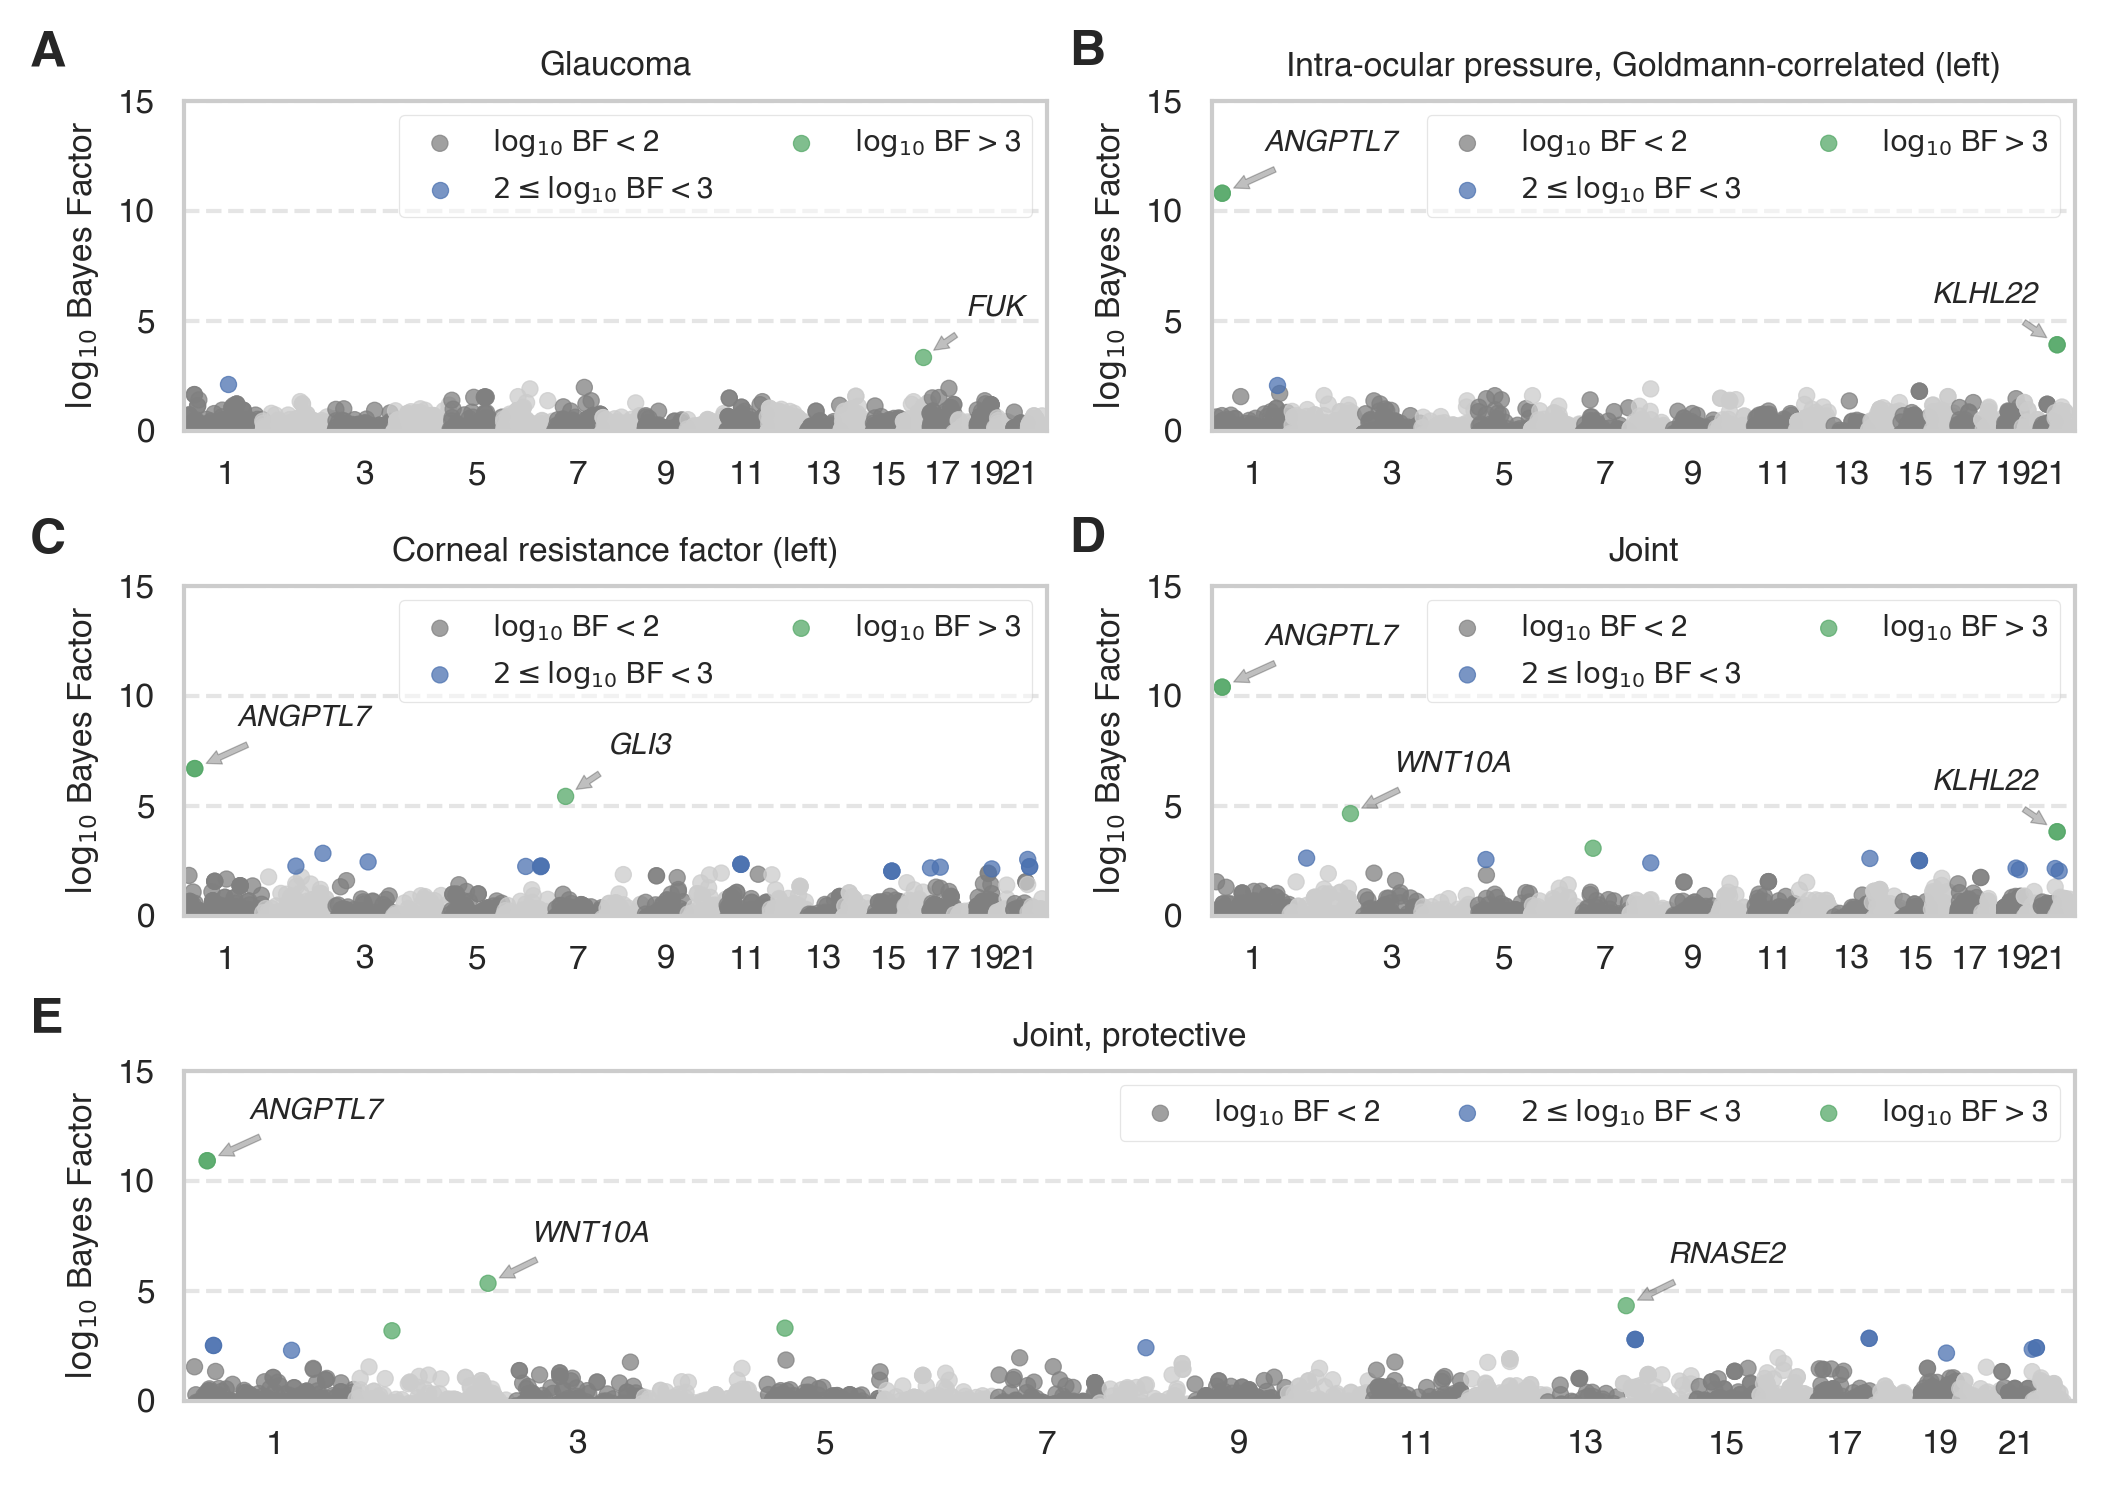

In [19]:
col = 'l10bf2'
print(col)

annotations = dict()
for fn in [
    '../results/glaucoma/HC276.glaucoma.chrpos.01_00001.out',
    '../results/glaucoma/INI5263.glaucoma.chrpos.01_00001.out',
    '../results/glaucoma/INI5265.glaucoma.chrpos.01_00001.out',
    '../results/glaucoma/f4traits.all.glaucoma.chrpos.01_00001.out',
    '../results/glaucoma/f4traits.prot.glaucoma.chrpos.01_00001.out',
]:
    annotations[fn] = list(get_annotations(fn, cutoff=3, col=col))
    if 'ANGPTL7' in annotations[fn] and 'MTOR' in annotations[fn]:
        annotations[fn].remove('MTOR')
    if 'SCARF2' in annotations[fn] and 'KLHL22' in annotations[fn]:
        annotations[fn].remove('SCARF2')
    tdf = read_results(fn)

fig = plt.figure(figsize=(7, 5), dpi=300)
# gs = gridspec.GridSpec(1, 1)
# ax = fig.add_subplot(gs[0, 0])
# ax.text(0, 1, 'Figure 2',
#         size=14, va='top')
# clean_axis(ax)
# gs.tight_layout(fig, rect=[0, 0.93, 1, 1])

gs = gridspec.GridSpec(3, 2)
axs = []
ax = fig.add_subplot(gs[0, 0])
fn = '../results/glaucoma/HC276.glaucoma.chrpos.01_00001.out'
ax,res = plot_manhattan(fn, ax, col=col, loc='upper right', ncol=2)
ax.set_ylim(0, 15)
# offsets = {'IL33':(0, 20), 'CCR3':(0, 10), 'IL17RA':(-25, 20), 'CTD-3064M3.3':(0, 20)}
offsets = dict(zip(annotations[fn], [[10, 10] for x in annotations[fn]]))
add_annotations(fn, ax, offsets, col=col)
title = phenos.loc['HC276', 'phenotype'].replace('_', ' ')
title = title[0].upper() + title[1:]
ax.set_title(title, fontsize=8)
axs.append(ax)

ax = fig.add_subplot(gs[0, 1])
fn = '../results/glaucoma/INI5263.glaucoma.chrpos.01_00001.out'
ax,res = plot_manhattan(fn, ax, col=col, loc='upper right', ncol=2)
ax.set_ylim(0, 15)
offsets = {'ANGPTL7':(10, 10), 'KLHL22':(-30, 10)}
add_annotations(fn, ax, offsets, col=col)
title = phenos.loc['INI5263', 'phenotype'].replace('_', ' ')
title = title[0].upper() + title[1:]
ax.set_title(title, fontsize=8)
axs.append(ax)

ax = fig.add_subplot(gs[1, 0])
fn = '../results/glaucoma/INI5265.glaucoma.chrpos.01_00001.out'
ax,res = plot_manhattan(fn, ax, col=col, loc='upper right', ncol=2)
ax.set_ylim(0, 15)
offsets = dict(zip(annotations[fn], [[10, 10] for x in annotations[fn]]))
add_annotations(fn, ax, offsets, col=col)
title = phenos.loc['INI5265', 'phenotype'].replace('_', ' ')
title = title[0].upper() + title[1:]
ax.set_title(title, fontsize=8)
axs.append(ax)

ax = fig.add_subplot(gs[1, 1])
fn = '../results/glaucoma/f4traits.all.glaucoma.chrpos.01_00001.out'
ax,res = plot_manhattan(fn, ax, col=col, loc='upper right', ncol=2)
ax.set_ylim(0, 15)
offsets = {'ANGPTL7':(10, 10), 'WNT10A':(10, 10), 'KLHL22':(-30, 10)}
add_annotations(fn, ax, offsets, col=col)
ax.set_title('Joint', fontsize=8)
axs.append(ax)

ax = fig.add_subplot(gs[2, 0:2])
fn = '../results/glaucoma/f4traits.prot.glaucoma.chrpos.01_00001.out'
ax,res = plot_manhattan(fn, ax, col=col, loc='upper right', ncol=3)
ax.set_ylim(0, 15)
offsets = dict(zip(annotations[fn], [[10, 10] for x in annotations[fn]]))
add_annotations(fn, ax, offsets, col=col)
ax.set_title('Joint, protective', fontsize=8)

t = fig.text(0.005, 0.96, 'A', weight='bold', 
             size=12)
t = fig.text(0.5, 0.96, 'B', weight='bold', 
             size=12)
t = fig.text(0.005, 0.635, 'C', weight='bold', 
             size=12)
t = fig.text(0.5, 0.635, 'D', weight='bold', 
             size=12)
t = fig.text(0.005, 0.315, 'E', weight='bold', 
             size=12)

gs.tight_layout(fig, rect=[0, 0, 1, 1])
plt.savefig('glaucoma_manhattan_{}.pdf'.format(col))

bma


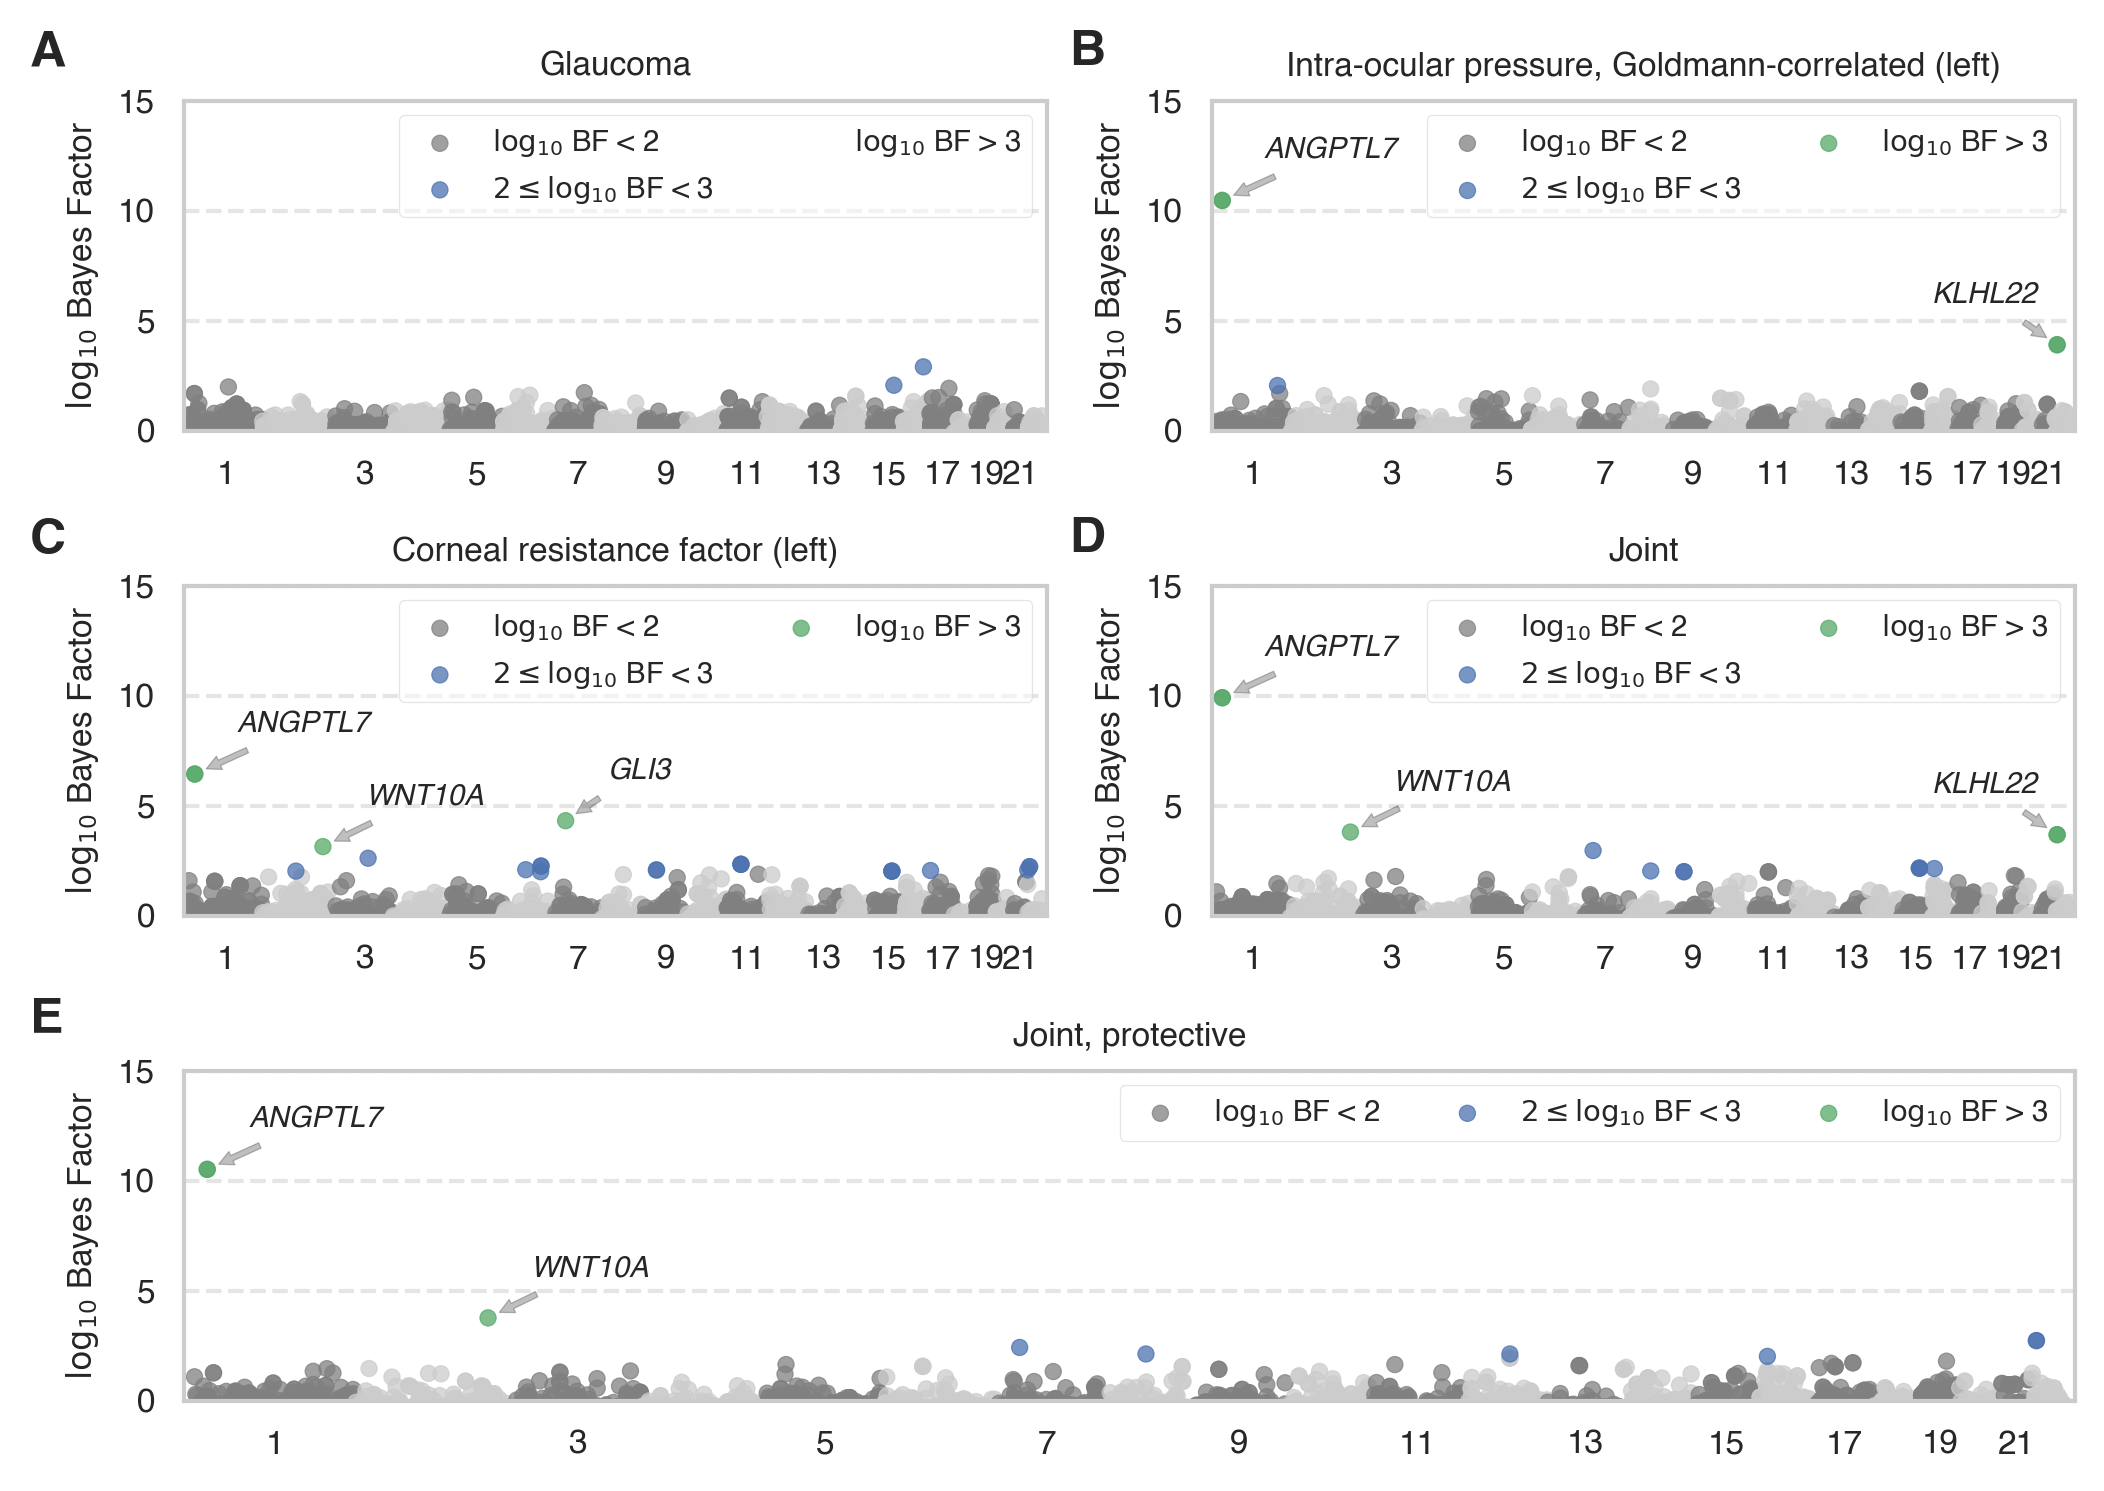

In [20]:
col = 'bma'
print(col)

annotations = dict()
for fn in [
    '../results/glaucoma/HC276.glaucoma.chrpos.01_00001.out',
    '../results/glaucoma/INI5263.glaucoma.chrpos.01_00001.out',
    '../results/glaucoma/INI5265.glaucoma.chrpos.01_00001.out',
    '../results/glaucoma/f4traits.all.glaucoma.chrpos.01_00001.out',
    '../results/glaucoma/f4traits.prot.glaucoma.chrpos.01_00001.out',
]:
    annotations[fn] = list(get_annotations(fn, cutoff=3, col=col))
    if 'ANGPTL7' in annotations[fn] and 'MTOR' in annotations[fn]:
        annotations[fn].remove('MTOR')
    if 'SCARF2' in annotations[fn] and 'KLHL22' in annotations[fn]:
        annotations[fn].remove('SCARF2')
    tdf = read_results(fn)

fig = plt.figure(figsize=(7, 5), dpi=300)
# gs = gridspec.GridSpec(1, 1)
# ax = fig.add_subplot(gs[0, 0])
# ax.text(0, 1, 'Figure 2',
#         size=14, va='top')
# clean_axis(ax)
# gs.tight_layout(fig, rect=[0, 0.93, 1, 1])

gs = gridspec.GridSpec(3, 2)
axs = []
ax = fig.add_subplot(gs[0, 0])
fn = '../results/glaucoma/HC276.glaucoma.chrpos.01_00001.out'
ax,res = plot_manhattan(fn, ax, col=col, loc='upper right', ncol=2)
ax.set_ylim(0, 15)
# offsets = {'IL33':(0, 20), 'CCR3':(0, 10), 'IL17RA':(-25, 20), 'CTD-3064M3.3':(0, 20)}
offsets = dict(zip(annotations[fn], [[10, 10] for x in annotations[fn]]))
add_annotations(fn, ax, offsets, col=col)
title = phenos.loc['HC276', 'phenotype'].replace('_', ' ')
title = title[0].upper() + title[1:]
ax.set_title(title, fontsize=8)
axs.append(ax)

ax = fig.add_subplot(gs[0, 1])
fn = '../results/glaucoma/INI5263.glaucoma.chrpos.01_00001.out'
ax,res = plot_manhattan(fn, ax, col=col, loc='upper right', ncol=2)
ax.set_ylim(0, 15)
offsets = {'ANGPTL7':(10, 10), 'KLHL22':(-30, 10)}
add_annotations(fn, ax, offsets, col=col)
title = phenos.loc['INI5263', 'phenotype'].replace('_', ' ')
title = title[0].upper() + title[1:]
ax.set_title(title, fontsize=8)
axs.append(ax)

ax = fig.add_subplot(gs[1, 0])
fn = '../results/glaucoma/INI5265.glaucoma.chrpos.01_00001.out'
ax,res = plot_manhattan(fn, ax, col=col, loc='upper right', ncol=2)
ax.set_ylim(0, 15)
offsets = dict(zip(annotations[fn], [[10, 10] for x in annotations[fn]]))
add_annotations(fn, ax, offsets, col=col)
title = phenos.loc['INI5265', 'phenotype'].replace('_', ' ')
title = title[0].upper() + title[1:]
ax.set_title(title, fontsize=8)
axs.append(ax)

ax = fig.add_subplot(gs[1, 1])
fn = '../results/glaucoma/f4traits.all.glaucoma.chrpos.01_00001.out'
ax,res = plot_manhattan(fn, ax, col=col, loc='upper right', ncol=2)
ax.set_ylim(0, 15)
offsets = {'ANGPTL7':(10, 10), 'WNT10A':(10, 10), 'KLHL22':(-30, 10)}
add_annotations(fn, ax, offsets, col=col)
ax.set_title('Joint', fontsize=8)
axs.append(ax)

ax = fig.add_subplot(gs[2, 0:2])
fn = '../results/glaucoma/f4traits.prot.glaucoma.chrpos.01_00001.out'
ax,res = plot_manhattan(fn, ax, col=col, loc='upper right', ncol=3)
ax.set_ylim(0, 15)
offsets = dict(zip(annotations[fn], [[10, 10] for x in annotations[fn]]))
add_annotations(fn, ax, offsets, col=col)
ax.set_title('Joint, protective', fontsize=8)

t = fig.text(0.005, 0.96, 'A', weight='bold', 
             size=12)
t = fig.text(0.5, 0.96, 'B', weight='bold', 
             size=12)
t = fig.text(0.005, 0.635, 'C', weight='bold', 
             size=12)
t = fig.text(0.5, 0.635, 'D', weight='bold', 
             size=12)
t = fig.text(0.005, 0.315, 'E', weight='bold', 
             size=12)

gs.tight_layout(fig, rect=[0, 0, 1, 1])
plt.savefig('glaucoma_manhattan_{}.pdf'.format(col))

### Table

In [21]:
results = dict()
col = 'bma'
    
fns = ['../results/glaucoma/HC276.glaucoma.chrpos.01_00001.out',
       '../results/glaucoma/INI5263.glaucoma.chrpos.01_00001.out',
       '../results/glaucoma/INI5265.glaucoma.chrpos.01_00001.out',
       '../results/glaucoma/f4traits.all.glaucoma.chrpos.01_00001.out',
       '../results/glaucoma/f4traits.prot.glaucoma.chrpos.01_00001.out',
      ]

for fn in fns:
    tdf = read_results(fn)
    tdf = tdf.sort_values(by=col, ascending=False)
    results['.'.join(fn.split('/')[3].split('.')[0:2]).replace('.glaucoma', '')] = tdf

# fn = '../results/asthma/INI3062.chrpos.01_00001.out'
# tdf = read_results(fn)
# tdf = tdf.sort_values(by='l10bf', ascending=False)
# results['INI3062'] = tdf
# 
# fn = '../results/asthma/INI3063.chrpos.01_00001.out'
# tdf = read_results(fn)
# tdf = tdf.sort_values(by='l10bf', ascending=False)
# results['INI3063'] = tdf
# 
# fn = '../results/asthma/HC382.chrpos.01_00001.out'
# tdf = read_results(fn)
# tdf = tdf.sort_values(by='l10bf', ascending=False)
# results['HC382'] = tdf
# 
# fn = '../results/asthma/f4traits.chrpos.01_00001.out'
# tdf = read_results(fn)
# tdf = tdf.sort_values(by='l10bf', ascending=False)
# results['f4'] = tdf

results_pd = pd.Panel(results)

In [22]:
# table_index = tdf[(tdf['l10bf'] > 5) & (tdf['chrom'] != 6)].index
table_index = ['ANGPTL7', 'WNT10A', 'RNASE2', 'GLI3', 'KLHL22', 'FUK']
table = results_pd.loc[:, table_index, 'l10bf']
cols = ['Glaucoma', 'Intra-ocular pressure, Goldmann-correlated', 'Corneal resistance factor', 
        'Joint', 'Joint, protective']
table.columns = cols
table = table.sort_values(by='Joint, protective', ascending=False)
table = table.fillna(1000).round(1).astype(str).replace('1000.0', '')
table = table[['Joint, protective', 'Joint', 'Glaucoma', 
               'Intra-ocular pressure, Goldmann-correlated', 'Corneal resistance factor']]
print(table)

        Joint, protective Joint Glaucoma  \
ANGPTL7              10.1   9.4      1.7   
KLHL22                3.1   3.6     -0.2   
GLI3                  2.9   2.9     -0.3   
WNT10A                2.2   3.0     -0.3   
RNASE2               -1.3  -0.3      0.4   
FUK                  -6.5  -2.3      2.5   

        Intra-ocular pressure, Goldmann-correlated Corneal resistance factor  
ANGPTL7                                       10.1                       6.2  
KLHL22                                         3.9                       2.2  
GLI3                                          -0.7                       3.2  
WNT10A                                        -0.5                       3.5  
RNASE2                                        -1.0                      -1.1  
FUK                                           -2.1                      -2.1  


In [23]:
print(table.to_latex())

\begin{tabular}{llllll}
\toprule
{} & Joint, protective & Joint & Glaucoma & Intra-ocular pressure, Goldmann-correlated & Corneal resistance factor \\
\midrule
ANGPTL7 &              10.1 &   9.4 &      1.7 &                                       10.1 &                       6.2 \\
KLHL22  &               3.1 &   3.6 &     -0.2 &                                        3.9 &                       2.2 \\
GLI3    &               2.9 &   2.9 &     -0.3 &                                       -0.7 &                       3.2 \\
WNT10A  &               2.2 &   3.0 &     -0.3 &                                       -0.5 &                       3.5 \\
RNASE2  &              -1.3 &  -0.3 &      0.4 &                                       -1.0 &                      -1.1 \\
FUK     &              -6.5 &  -2.3 &      2.5 &                                       -2.1 &                      -2.1 \\
\bottomrule
\end{tabular}



### Forest Plot

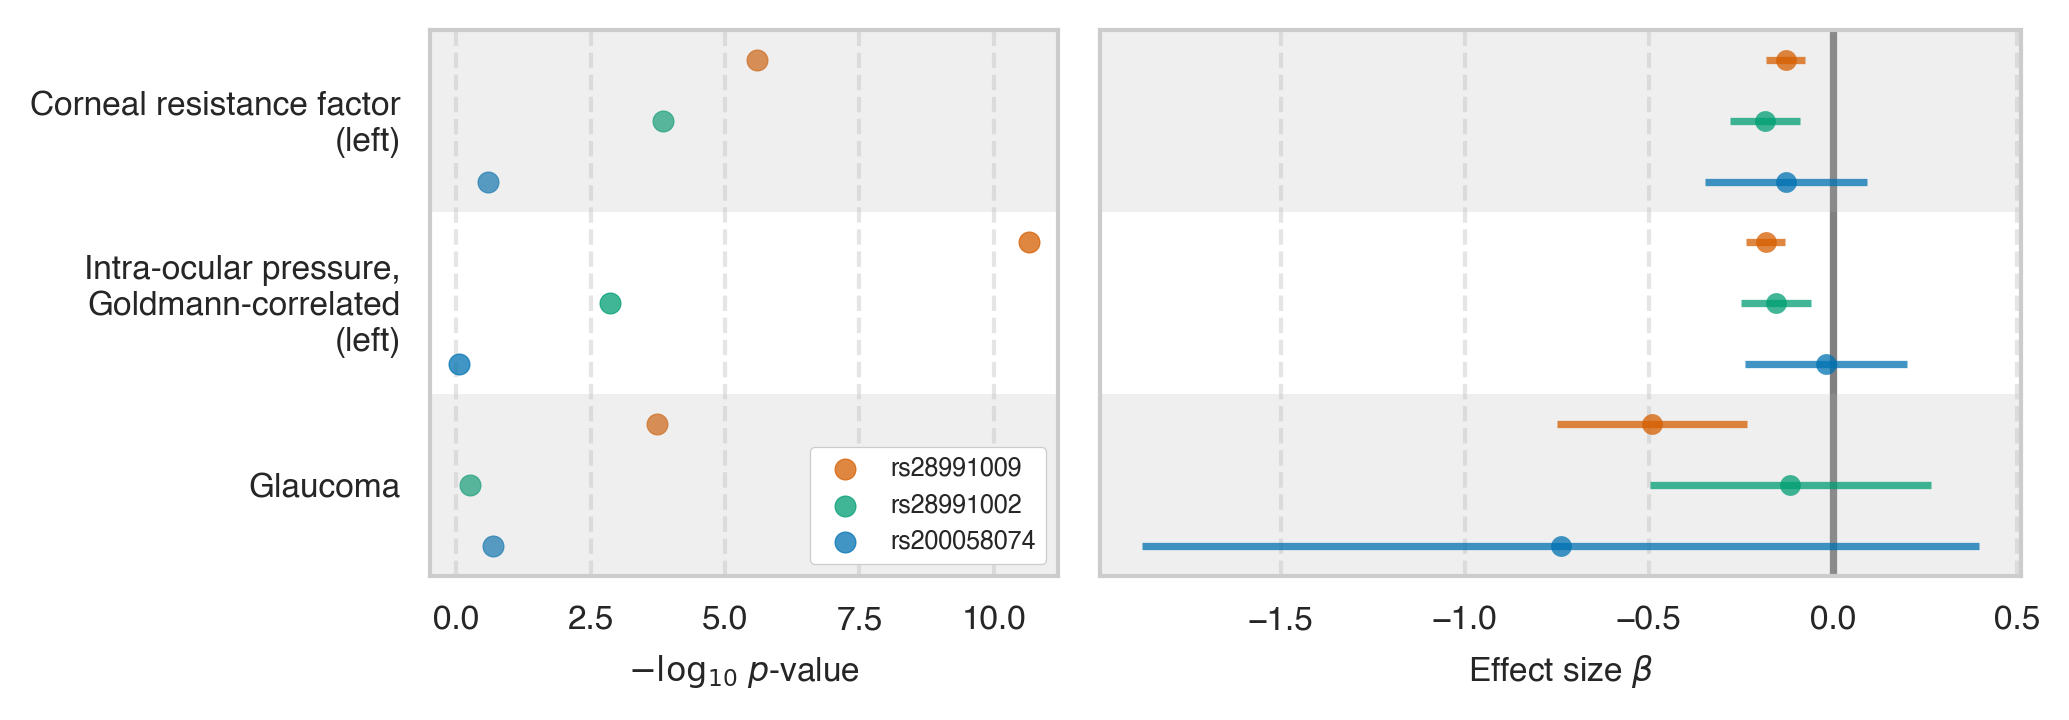

In [24]:
ps = ['HC276', 'INI5263', 'INI5265']
gwas_res = {}
for p in ps:
    gwas_res[p] = make_stan_input_files.get_results(p)
    gwas_res[p] = gwas_res[p].loc[varinfo['ID']]
    gwas_res[p]['beta_upper'] = gwas_res[p]['BETA'] + 1.96 * gwas_res[p]['SE']
    gwas_res[p]['beta_lower'] = gwas_res[p]['BETA'] - 1.96 * gwas_res[p]['SE']
gwas_res = pd.Panel(gwas_res)

angptl7 = gene_info[gene_info.gene_name == 'ANGPTL7'].index[0]
variants = list(varinfo_f.loc[(varinfo_f.Gene == angptl7) & 
                              (varinfo_f['maf'] > 0.0005) &
                              (varinfo_f['maf'] < 0.01) &
                              (varinfo_f['all_filters'] == 0),
                              'ID'])
gwas_res.loc[:, variants, 'BETA']

fig = plt.figure(figsize=(7, 2.5), dpi=300)
gs = gridspec.GridSpec(1, 2, width_ratios=[1.5, 2.2])

forest_plot(ps, variants, gs, legend_loc='lower right')

gs.tight_layout(fig, rect=[0, 0, 1, 1], w_pad=1)
plt.savefig('glaucoma_forest.pdf')

KeyError: '../results/glaucoma/HC276.glaucoma.chrpos.01_00001.out'

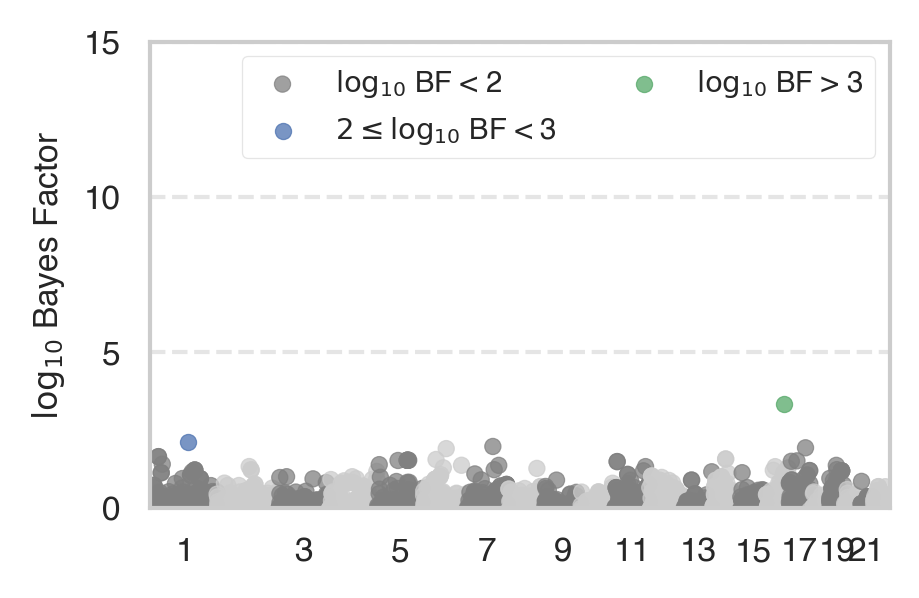

In [49]:
col = 'bma'
print(col)

annotations = dict()
for fn in [
    '../results/glaucoma/HC276.glaucoma.chrpos.01_00001.out',
    '../results/glaucoma/INI5263.glaucoma.chrpos.01_00001.out',
    '../results/glaucoma/INI5265.glaucoma.chrpos.01_00001.out',
    '../results/glaucoma/f4traits.all.glaucoma.chrpos.01_00001.out',
    '../results/glaucoma/f4traits.prot.glaucoma.chrpos.01_00001.out',
]:
    annotations[fn] = list(get_annotations(fn, cutoff=3, col=col))
    if 'ANGPTL7' in annotations[fn] and 'MTOR' in annotations[fn]:
        annotations[fn].remove('MTOR')
    if 'SCARF2' in annotations[fn] and 'KLHL22' in annotations[fn]:
        annotations[fn].remove('SCARF2')
    tdf = read_results(fn)

fig = plt.figure(figsize=(7, 7), dpi=300)
# gs = gridspec.GridSpec(1, 1)
# ax = fig.add_subplot(gs[0, 0])
# ax.text(0, 1, 'Figure 2',
#         size=14, va='top')
# clean_axis(ax)
# gs.tight_layout(fig, rect=[0, 0.93, 1, 1])

gs = gridspec.GridSpec(3, 2)
axs = []
ax = fig.add_subplot(gs[0, 0])
fn = '../results/glaucoma/HC276.glaucoma.chrpos.01_00001.out'
ax,res = plot_manhattan(fn, ax, col=col, loc='upper right', ncol=2)
ax.set_ylim(0, 15)
# offsets = {'IL33':(0, 20), 'CCR3':(0, 10), 'IL17RA':(-25, 20), 'CTD-3064M3.3':(0, 20)}
offsets = dict(zip(annotations[fn], [[10, 10] for x in annotations[fn]]))
add_annotations(fn, ax, offsets, col=col)
title = phenos.loc['HC276', 'phenotype'].replace('_', ' ')
title = title[0].upper() + title[1:]
ax.set_title(title, fontsize=8)
axs.append(ax)

ax = fig.add_subplot(gs[0, 1])
fn = '../results/glaucoma/INI5263.glaucoma.chrpos.01_00001.out'
ax,res = plot_manhattan(fn, ax, col=col, loc='upper right', ncol=2)
ax.set_ylim(0, 15)
offsets = {'ANGPTL7':(10, 10), 'KLHL22':(-30, 10)}
add_annotations(fn, ax, offsets, col=col)
title = phenos.loc['INI5263', 'phenotype'].replace('_', ' ')
title = title[0].upper() + title[1:]
ax.set_title(title, fontsize=8)
axs.append(ax)

ax = fig.add_subplot(gs[1, 0])
fn = '../results/glaucoma/INI5265.glaucoma.chrpos.01_00001.out'
ax,res = plot_manhattan(fn, ax, col=col, loc='upper right', ncol=2)
ax.set_ylim(0, 15)
offsets = dict(zip(annotations[fn], [[10, 10] for x in annotations[fn]]))
add_annotations(fn, ax, offsets, col=col)
title = phenos.loc['INI5265', 'phenotype'].replace('_', ' ')
title = title[0].upper() + title[1:]
ax.set_title(title, fontsize=8)
axs.append(ax)

ax = fig.add_subplot(gs[1, 1])
fn = '../results/glaucoma/f4traits.all.glaucoma.chrpos.01_00001.out'
ax,res = plot_manhattan(fn, ax, col=col, loc='upper right', ncol=2)
ax.set_ylim(0, 15)
offsets = {'ANGPTL7':(10, 10), 'WNT10A':(10, 10), 'KLHL22':(-30, 10)}
add_annotations(fn, ax, offsets, col=col)
ax.set_title('Joint', fontsize=8)
axs.append(ax)

ax = fig.add_subplot(gs[2, 0:2])
fn = '../results/glaucoma/f4traits.prot.glaucoma.chrpos.01_00001.out'
ax,res = plot_manhattan(fn, ax, col=col, loc='upper right', ncol=3)
ax.set_ylim(0, 15)
offsets = dict(zip(annotations[fn], [[10, 10] for x in annotations[fn]]))
add_annotations(fn, ax, offsets, col=col)
ax.set_title('Joint, protective', fontsize=8)

gs.tight_layout(fig, rect=[0, 0.28, 1, 1])

gs = gridspec.GridSpec(1, 2, width_ratios=[1.5, 2.2])
out = forest_plot(ps, variants, gs, legend_loc='lower right')
gs.tight_layout(fig, rect=[0, 0, 1, 0.3])

t = fig.text(0.005, 0.96, 'A', weight='bold', 
             size=12)
t = fig.text(0.5, 0.96, 'B', weight='bold', 
             size=12)
t = fig.text(0.005, 0.735, 'C', weight='bold', 
             size=12)
t = fig.text(0.5, 0.735, 'D', weight='bold', 
             size=12)
t = fig.text(0.005, 0.495, 'E', weight='bold', 
             size=12)
t = fig.text(0.005, 0.275, 'F', weight='bold', 
             size=12)

plt.savefig('glaucoma_combined.pdf')

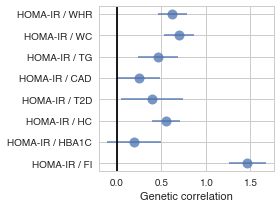

In [29]:
s = """1.467,0.1041,homa-ir/fi
0.19,0.1544,homa-ir/hba1c
0.043,0.04852,homa-ir/height
0.548,0.08,homa-ir/hc
0.393,0.176,homa-ir/t2d
0.461,0.1154,homa-ir/tg
0.7,0.08443,homa-ir/wc
0.624,0.083,homa-ir/whr""".split()

s = """1.467,0.1041,homa-ir/fi
0.19,0.1544,homa-ir/hba1c
0.043,0.04852,homa-ir/height
0.548,0.08,homa-ir/hc
0.393,0.176,homa-ir/t2d
0.244,0.122,homa-ir/cad
0.461,0.1154,homa-ir/tg
0.7,0.08443,homa-ir/wc
0.624,0.083,homa-ir/whr""".split()

s = """1.467,0.1041,homa-ir/fi
0.19,0.1544,homa-ir/hba1c
0.548,0.08,homa-ir/hc
0.393,0.176,homa-ir/t2d
0.244,0.122,homa-ir/cad
0.461,0.1154,homa-ir/tg
0.7,0.08443,homa-ir/wc
0.624,0.083,homa-ir/whr""".split()

tdf = pd.DataFrame([x.split(',') for x in s], columns=['estimate', 'SE', 'label'])
tdf = tdf.set_index('label')
tdf = tdf.astype(float)
tdf['upper'] = tdf['estimate'] + 1.96 * tdf['SE']
tdf['lower'] = tdf['estimate'] - 1.96 * tdf['SE']
tdf['count'] = np.arange(tdf.shape[0])

fig,ax = plt.subplots(figsize=(4, 3))
ax.errorbar(
    tdf['estimate'],
    tdf['count'],
    alpha=0.75, 
    xerr=[tdf['estimate'] - tdf['lower'], tdf['upper'] - tdf['estimate']],
    fmt='o', 
    ms=10,
)
ymin,ymax = ax.get_ylim()
ax.vlines(0, ymin, ymax)
ax.set_yticks(tdf['count'])
ax.set_yticklabels([x.upper().replace('/', ' / ') for x in tdf.index])
ax.set_xlabel('Genetic correlation')
ax.set_ylim(ymin, ymax)

plt.tight_layout()
plt.savefig('forest.pdf')